# Прогнозирование рисков ДТП в каршеринговой компании

**Описание исследования**

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

**Цель исследования:**

Подобрать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties) и основе модели исследовать основные факторы ДТП.
Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
 - Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
 - Какие ещё факторы нужно учесть?
 - Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

**Описание исходных данных**

 - *collisions* — общая информация о ДТП

     - Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.
     
 - *parties* — информация об участниках ДТП

    - Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.
    
 - *vehicles* — информация о пострадавших машинах

    - Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

## Импорты и настройки

In [1]:
!pip install -U scikit-learn -q
!pip install sweetviz -q
!pip install phik -q
!pip install optuna -q
!pip install matplotlib==3.4 -q # немношк обновим, что б графики сделать покрасивее(было 3.3.4)
!pip install shap -q

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time

import optuna
import shap

from catboost import CatBoostClassifier
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, classification_report, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
import sweetviz as sv
from sqlalchemy import create_engine

In [3]:
# обьявляем константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
# настраиваем отображение таблиц
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### Дополнительные функции

In [5]:
def cross_params(cross_seach):
    """Визуализация параметров кросс-валидации"""
    df_cg=pd.DataFrame(cross_seach.cv_results_)[
    ['rank_test_score', 'mean_test_score','params', 'mean_fit_time']
    ].sort_values('rank_test_score')[:5].reset_index(drop=True)
    print("Парамерты лучшей модели",cross_seach.best_params_)
    print("F1 с лучшими гиперпараметрами на кросс-валидации :", cross_seach.best_score_)
    display(df_cg)

In [6]:
def model_score(model, X_test, y_test):
    """Оценка производительности модели на тестовой выборке"""
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,7), dpi=100)
    y_pred = model.predict(X_test)

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=axes[0])
    axes[0].set_title("Confusion Matrix")
    preds = model.predict_proba(X_test)[:,1]
    RocCurveDisplay.from_predictions(y_test, preds, ax=axes[1])
    axes[1].plot([0,1], [0,1], linestyle='dashed', label='Random prediction')
    axes[1].set_title("График ROC-AUC")
    axes[1].legend()
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="CatBoostClassifier",ax=axes[2])
    axes[2].set_title("Кривая полноты и точности")
    axes[2].legend()

    roc_auc = roc_auc_score(y_test, preds)

    print('ROC-AUC = ', roc_auc)
    print(classification_report(y_test, y_pred))

## Подключитесь к базе. Загрузите таблицы sql

In [7]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

engine = create_engine(connection_string) 

## Проведите первичное исследование таблиц

In [8]:
#проверяем соответствует ли количество таблиц условию задачи;
inform_schema = '''SELECT table_name
                   FROM information_schema.tables
                   WHERE table_schema = 'public';
                '''

inform_schema = pd.read_sql_query(inform_schema, con=engine)
inform_schema

,table_name
0,case_ids
1,collisions
2,parties
3,vehicles


In [9]:
all_table = inform_schema['table_name'].to_list()
all_table

['case_ids', 'collisions', 'parties', 'vehicles']

In [10]:
# проверяем все ли таблицы имеют набор данных
for x in all_table:
    info_column_tbl = f"SELECT column_name, data_type FROM information_schema.columns WHERE table_name = '{x}';"
    info_column_tbl = pd.read_sql_query(info_column_tbl, con=engine)
    print(f'Набор и тип данных таблицы {x}')
    display(info_column_tbl)
    print()

Набор и тип данных таблицы case_ids


,column_name,data_type
0,case_id,text
1,db_year,text



Набор и тип данных таблицы collisions


,column_name,data_type
0,party_count,integer
1,intersection,integer
2,distance,real
3,collision_date,date
4,collision_time,time without time zone
5,location_type,text
6,collision_damage,text
7,case_id,text
8,pcf_violation_category,text
9,type_of_collision,text



Набор и тип данных таблицы parties


,column_name,data_type
0,cellphone_in_use,integer
1,party_number,integer
2,at_fault,integer
3,insurance_premium,integer
4,id,integer
5,case_id,text
6,party_drug_physical,text
7,party_type,text
8,party_sobriety,text



Набор и тип данных таблицы vehicles


,column_name,data_type
0,id,integer
1,party_number,integer
2,vehicle_age,integer
3,case_id,text
4,vehicle_type,text
5,vehicle_transmission,text


In [11]:
# кратко осмотрим данные в таблицах
for x in all_table:
    info_column_tbl = f"SELECT * FROM {x} LIMIT 5;"
    info_column_tbl = pd.read_sql_query(info_column_tbl, con=engine)
    print(f'Первые 5 строк таблицы {x}')
    display(info_column_tbl)
    print()

Первые 5 строк таблицы case_ids


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021



Первые 5 строк таблицы collisions


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00



Первые 5 строк таблицы parties


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0



Первые 5 строк таблицы vehicles


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [12]:
# проверяем первичные ключи
key_query = '''SELECT *
               FROM information_schema.key_column_usage
               WHERE constraint_schema = 'public'
             '''
key_query = pd.read_sql_query(key_query, con=engine)
key_query

,constraint_catalog,constraint_schema,constraint_name,table_catalog,table_schema,table_name,column_name,ordinal_position,position_in_unique_constraint
0,data-science-vehicle-db,public,case_ids_pk,data-science-vehicle-db,public,case_ids,case_id,1,NaN
1,data-science-vehicle-db,public,parties_pk,data-science-vehicle-db,public,parties,id,1,NaN
2,data-science-vehicle-db,public,vehicles_pk,data-science-vehicle-db,public,vehicles,id,1,NaN
3,data-science-vehicle-db,public,collisions_case_ids_case_id_fk,data-science-vehicle-db,public,collisions,case_id,1,1.0
4,data-science-vehicle-db,public,parties_case_ids_case_id_fk,data-science-vehicle-db,public,parties,case_id,1,1.0
5,data-science-vehicle-db,public,vehicles_case_ids_case_id_fk,data-science-vehicle-db,public,vehicles,case_id,1,1.0


**Промежуточные выводы по этапу**:
 - *Все ли таблицы имеют набор данных*:
   - наборы данных во всех таблицах соответствует предоставленной схеме, типы данных соответствуют,
 - *Соответствует ли количество таблиц условию задачи*:
   - количество таблиц соответствует условию задачи и предоставленной схеме,
 - *Имеется ли общий ключ для связи таблиц*:
   - общий ключ case_id обьединяет таблицы схемы.

##  Проведите статистический анализ факторов ДТП

Проведем статистический анализ данных.
Общий план анализа:
 - постановка вопроса,
 - sql-запрос,
 - построение графика,
 - вывод.

**Выясним, в какие месяцы происходит наибольшее количество аварий. Проанализируем весь период наблюдений и 2012 год в одельности.**

In [13]:
month_query = ''' SELECT EXTRACT(MONTH from collision_date::timestamp) as Месяц,
                         COUNT(*) AS ДТП_за_месяц
                  FROM collisions
                  GROUP BY EXTRACT(MONTH from collision_date::timestamp);
              '''
month_query = pd.read_sql_query(month_query, con=engine)
month_query

,Месяц,ДТП_за_месяц
0,1.0,132044
1,2.0,128858
2,3.0,139581
3,4.0,130180
4,5.0,130316
5,6.0,102594
6,7.0,102227
7,8.0,104089
8,9.0,105159
9,10.0,112237


In [14]:
month_query_2012 = ''' SELECT EXTRACT(MONTH from collision_date::timestamp) as Месяц,
                              COUNT(*) AS ДТП_за_месяц
                       FROM collisions 
                       WHERE EXTRACT(YEAR from collision_date::timestamp) = 2012
                       GROUP BY EXTRACT(MONTH from collision_date::timestamp);
                   '''
month_query_2012 = pd.read_sql_query(month_query_2012, con=engine)
month_query_2012

,Месяц,ДТП_за_месяц
0,1.0,32020
1,2.0,30377
2,3.0,32498
3,4.0,29143
4,5.0,25168
5,6.0,3062
6,7.0,390
7,8.0,622
8,9.0,510
9,10.0,304


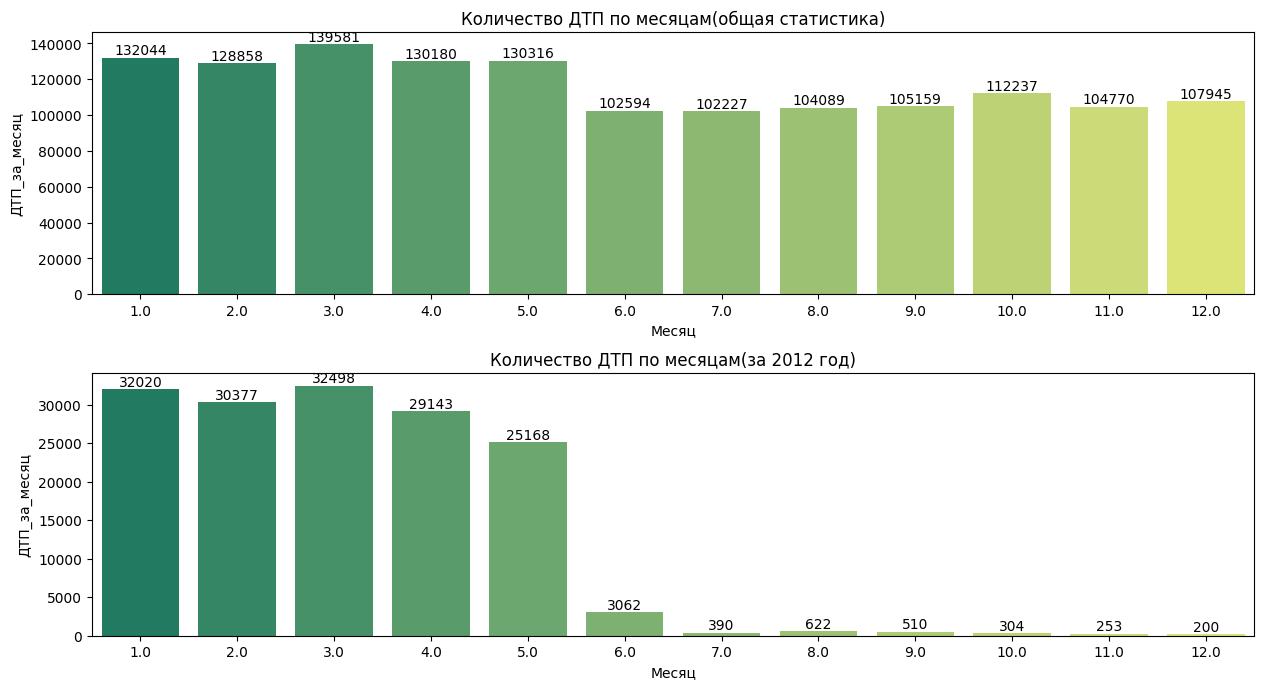

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=100, figsize=(15,8))

sns.barplot(x="Месяц", y="ДТП_за_месяц", data=month_query, ax=axes[0], palette='summer')
sns.barplot(x="Месяц", y="ДТП_за_месяц", data=month_query_2012, ax=axes[1], palette='summer')
axes[0].set_title('Количество ДТП по месяцам(общая статистика)')
axes[1].set_title('Количество ДТП по месяцам(за 2012 год)')
for i in axes[0].containers:
    axes[0].bar_label(i,)
for i in axes[1].containers:
    axes[1].bar_label(i,)
plt.subplots_adjust(hspace=0.3);

**Выводы**:
 - общая статистика показывает, что число ДТП возрастает в зимне-весенний период с января по май.
 - статистика 2012 года отличается от общей - здесь в целом почти все ДТП произошли в зимне-весенний период, на летне-осенние месяцы приходится ничтожное количество наблюдений. Тенденция это или ошибки при создании выборки? Ответить на этот вопрос мы к сожалению не можем.

**Выясним, в какие дни происходит наибольшее количество аварий. Проанализируем весь период наблюдений и 2012 год в одельности.**

In [16]:
day_query = ''' SELECT EXTRACT(DOW from collision_date::timestamp) as День,
                         COUNT(*) AS ДТП_в_конкретный_день
                  FROM collisions
                  GROUP BY EXTRACT(DOW from collision_date::timestamp);
              '''
day_query = pd.read_sql_query(day_query, con=engine)
day_query

,День,ДТП_в_конкретный_день
0,0.0,163407
1,1.0,195282
2,2.0,206914
3,3.0,206775
4,4.0,206823
5,5.0,229048
6,6.0,191751


In [17]:
day_query_2012 = ''' SELECT EXTRACT(DOW from collision_date::timestamp) as День,
                            COUNT(*) AS ДТП_в_конкретный_день
                       FROM collisions 
                       WHERE EXTRACT(YEAR from collision_date::timestamp) = 2012
                       GROUP BY EXTRACT(DOW from collision_date::timestamp);
                   '''
day_query_2012 = pd.read_sql_query(day_query_2012, con=engine)
day_query_2012

,День,ДТП_в_конкретный_день
0,0.0,18133
1,1.0,21335
2,2.0,22792
3,3.0,23259
4,4.0,22863
5,5.0,25187
6,6.0,20978


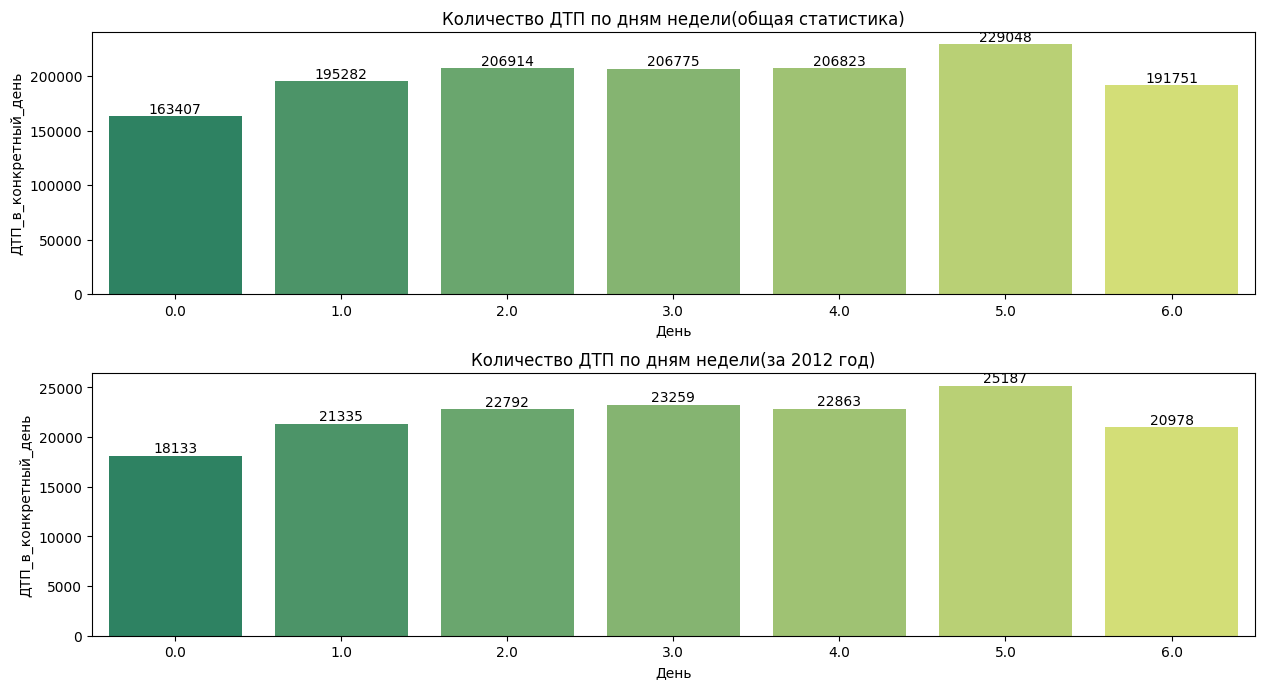

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=100, figsize=(15,8))

sns.barplot(x="День", y="ДТП_в_конкретный_день", data=day_query, ax=axes[0], palette='summer')
sns.barplot(x="День", y="ДТП_в_конкретный_день", data=day_query_2012, ax=axes[1], palette='summer')
axes[0].set_title('Количество ДТП по дням недели(общая статистика)')
axes[1].set_title('Количество ДТП по дням недели(за 2012 год)')
for i in axes[0].containers:
    axes[0].bar_label(i,)
for i in axes[1].containers:
    axes[1].bar_label(i,)
plt.subplots_adjust(hspace=0.3);

**Выводы:**
- общая статистика и 2012 год по дняи ДТП не различаются, основная масса аварий приходится на пт(ожидаемо, конец рабочей недели), минимумы пн и вс.

**Выясним, как состояние водителя влияет на ущерб автомобиля при ДТП.**

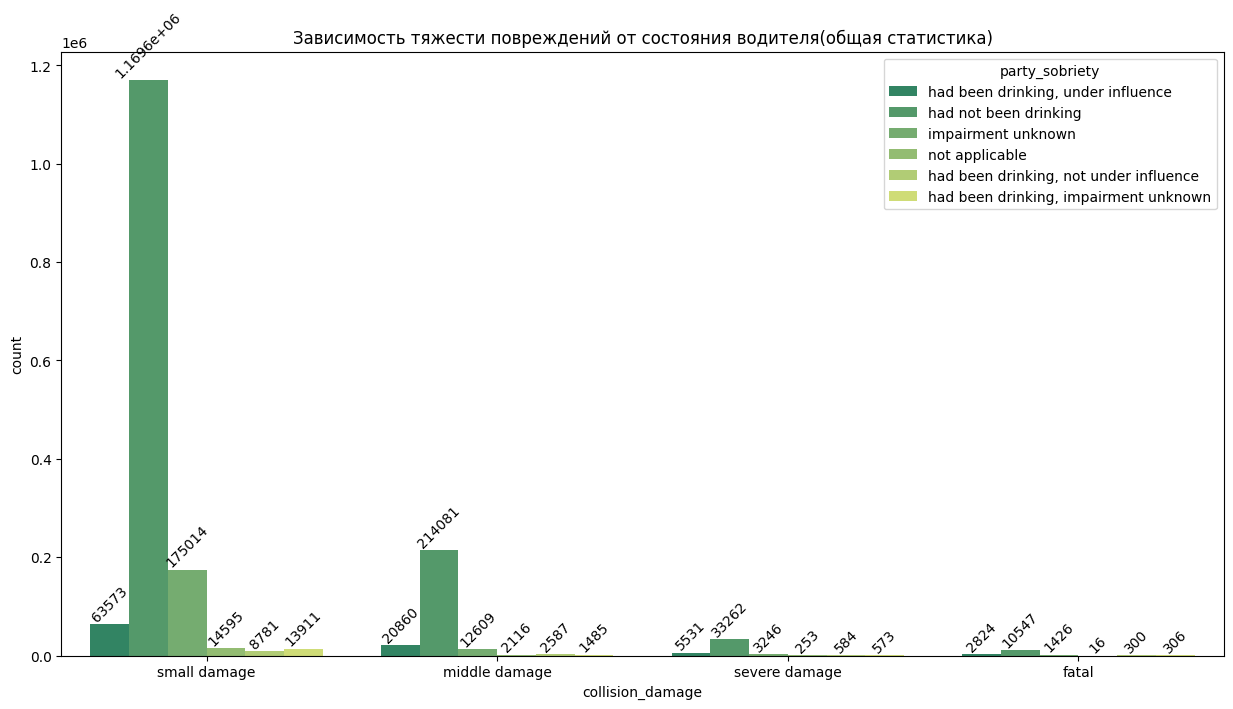

In [19]:
q2 = '''SELECT party_sobriety, collision_damage
        FROM (SELECT * FROM parties WHERE party_type='car') AS p
             JOIN (SELECT * FROM collisions WHERE collision_damage != 'scratch') AS c USING(case_id)
     '''
q2 = pd.read_sql_query(q2, con=engine)

fig, axes = plt.subplots(dpi=100, figsize=(15,8))
axes.set_title('Зависимость тяжести повреждений от состояния водителя(общая статистика)')
ax = sns.countplot(x='collision_damage', data=q2, hue='party_sobriety', ax=axes, palette='summer')
for i in ax.containers:
    ax.bar_label(i, rotation=45);

**Выводы:**
- большая часть наблюдений, где водители не употребляли спиртное, в остальном картина примерно одинаковая.Явной зависимости на графике не видно.

**Посмотрим, зависит ли ущерб от освещения места проишествия.**

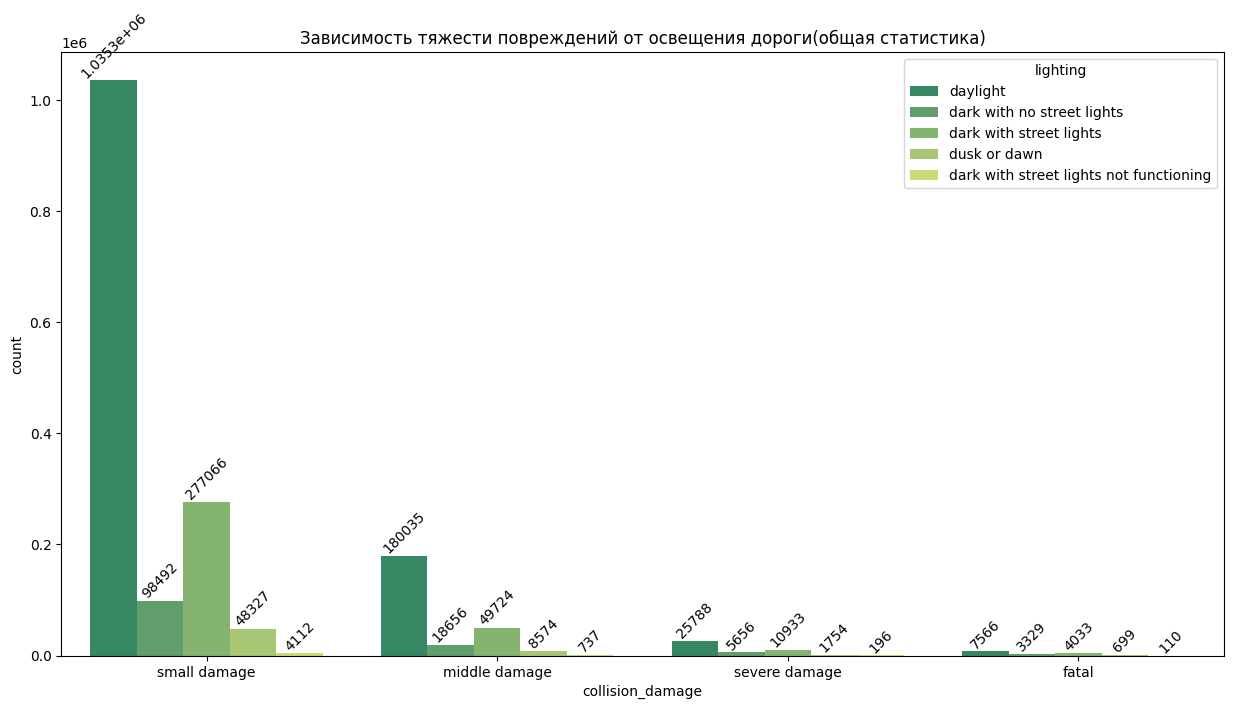

In [20]:
q3 = '''SELECT lighting, collision_damage
        FROM (SELECT * FROM parties WHERE party_type='car') AS p
             JOIN (SELECT * FROM collisions WHERE collision_damage != 'scratch') AS c USING(case_id)
     '''
q3 = pd.read_sql_query(q3, con=engine)

fig, axes = plt.subplots(dpi=100, figsize=(15,8))
axes.set_title('Зависимость тяжести повреждений от освещения дороги(общая статистика)')
ax = sns.countplot(x='collision_damage', data=q3, hue='lighting', ax=axes, palette='summer')
for i in ax.containers:
    ax.bar_label(i, rotation=45);

**Выводы**
 - похожая картина во всех группах, ярких закономерностей не наблюдается.

**Выясним, как связаны вина водителя в ДТП и состояние дорожного полотна.**

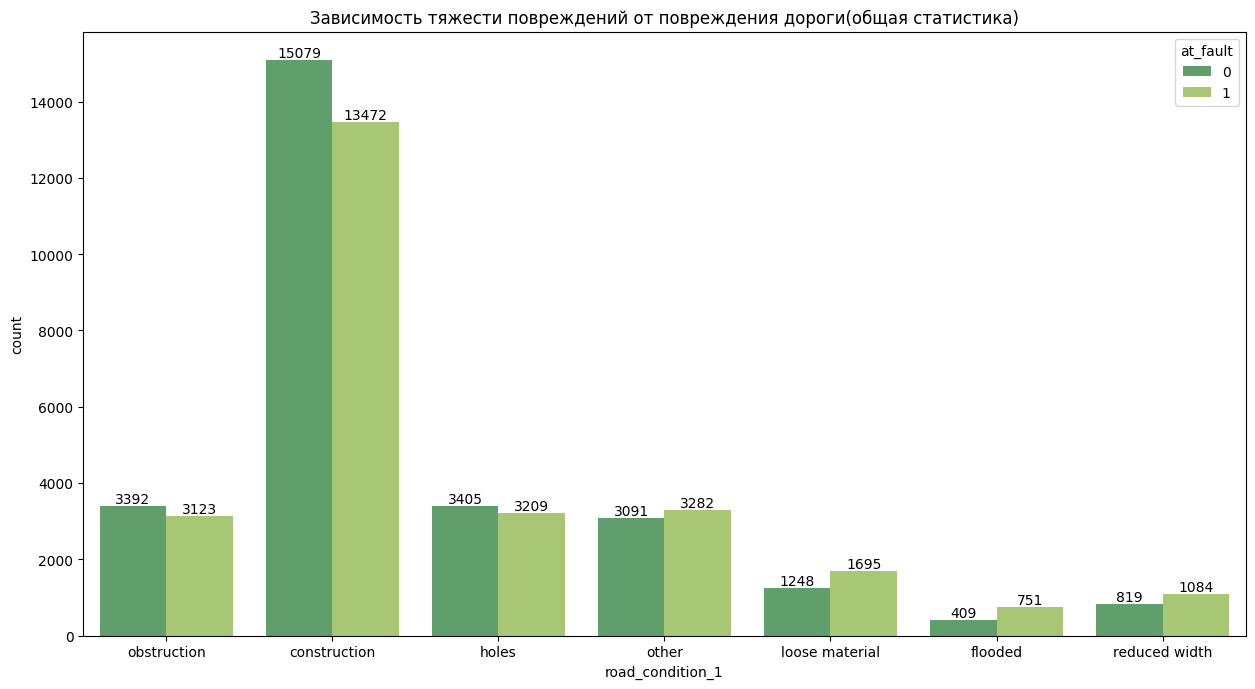

In [21]:
q4 = '''SELECT road_condition_1, at_fault
        FROM (SELECT * FROM parties WHERE party_type='car') AS p
             JOIN (SELECT * FROM collisions WHERE collision_damage != 'scratch' AND road_condition_1 != 'normal') AS c USING(case_id)
     '''
q4 = pd.read_sql_query(q4, con=engine)

fig, axes = plt.subplots(dpi=100, figsize=(15,8))
axes.set_title('Зависимость тяжести повреждений от повреждения дороги(общая статистика)')
ax = sns.countplot(x='road_condition_1', data=q4, hue='at_fault', ax=axes, palette='summer')
for i in ax.containers:
    ax.bar_label(i,);

**Выводы:**
 - судя по графику, водители чаще явяются виноватыми в случаях если состояние дороги - cыпучий материал на проезжей части, затоплена, уменьшена ширина проезда  - т.е. склонны игнорировать эти факторы или к ним не готовы.

**Посмотрим как состояние водителя влияет на его вину в ДТП.**

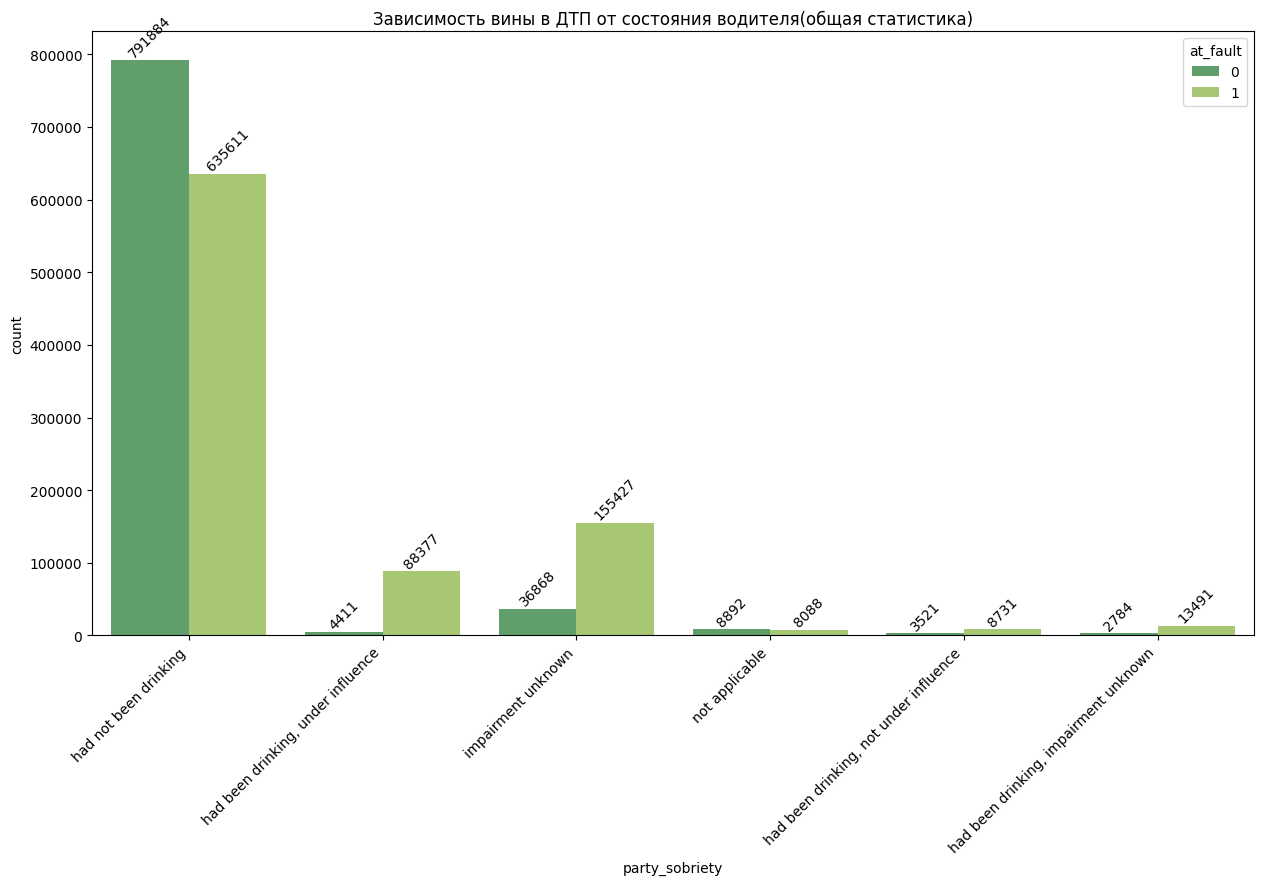

In [22]:
q5 = '''SELECT at_fault, party_sobriety
        FROM (SELECT * FROM parties WHERE party_type='car') AS p
             JOIN (SELECT * FROM collisions WHERE collision_damage != 'scratch') AS c USING(case_id)
     '''
q5 = pd.read_sql_query(q5, con=engine)

fig, axes = plt.subplots(dpi=100, figsize=(15,8))
axes.set_title('Зависимость вины в ДТП от состояния водителя(общая статистика)')
ax = sns.countplot(x='party_sobriety', data=q5, hue='at_fault', ax=axes, palette='summer')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
for i in ax.containers:
    ax.bar_label(i, rotation=45);

**Выводы:**
 - явно видим взаимосвязь вины в ДТП и состояния опьянения любого рода, сюда же подходит и неизвестное ухудшение. К сожалению мы мало знаем о преметной области, в случае РФ это можно было бы отнести к отказу о освидетельствования, что автоматически приравнивается к наличию алкоголя в крови, но здесь мы можем только оставить это как еизвестную величину.

**Посмотрим на зависимость вины от возраста автомобиля**

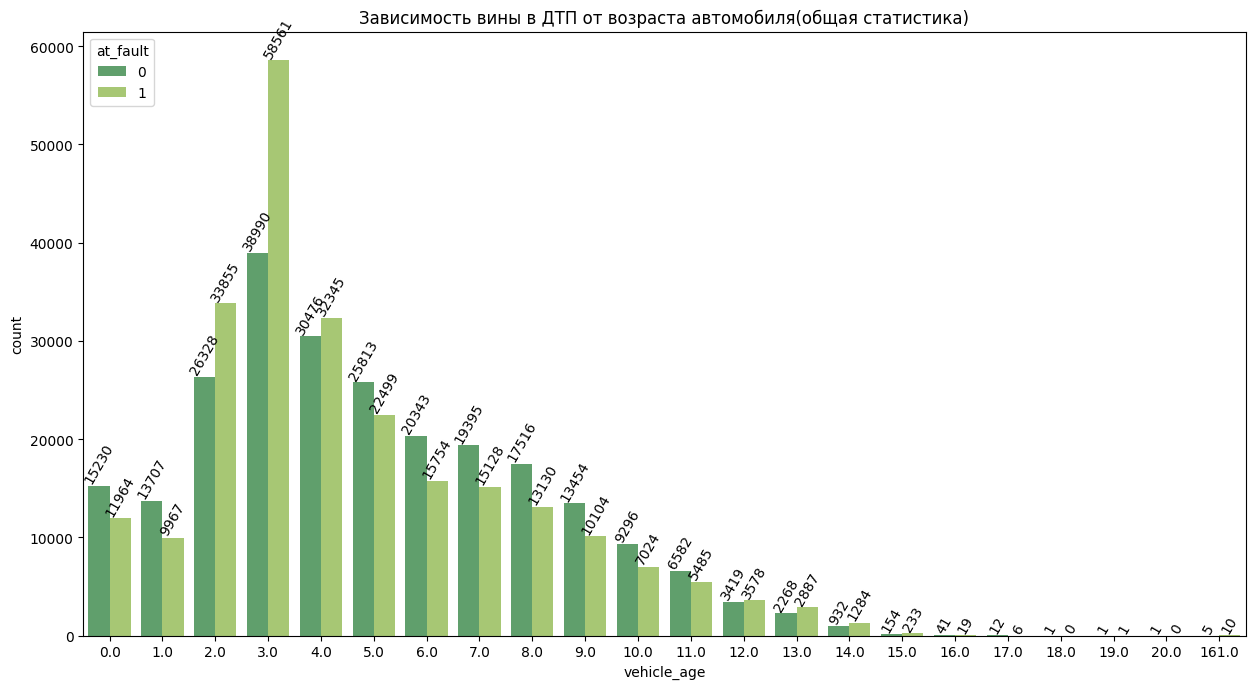

In [23]:
q6 = '''SELECT at_fault, vehicle_age
        FROM (SELECT * FROM parties WHERE party_type='car') AS p
             JOIN vehicles AS v USING(case_id, party_number)
             JOIN (SELECT * FROM collisions WHERE collision_damage != 'scratch') AS c USING(case_id)
     '''
q6 = pd.read_sql_query(q6, con=engine)

fig, axes = plt.subplots(dpi=100, figsize=(15,8))
axes.set_title('Зависимость вины в ДТП от возраcта автомобиля(общая статистика)')
ax = sns.countplot(x='vehicle_age', data=q6, hue='at_fault', ax=axes, palette='summer')
for i in ax.containers:
    ax.bar_label(i, rotation=60);

**Выводы**
- видим интересную закономерность, что при использовании автомобиля 2-4 лет в ДТП чаще тсановится виноват водитель. Так же график нам показывает, что у нас есть выбросы, поправим их при обработке данных.

**Зависимость урона от возраста авто**

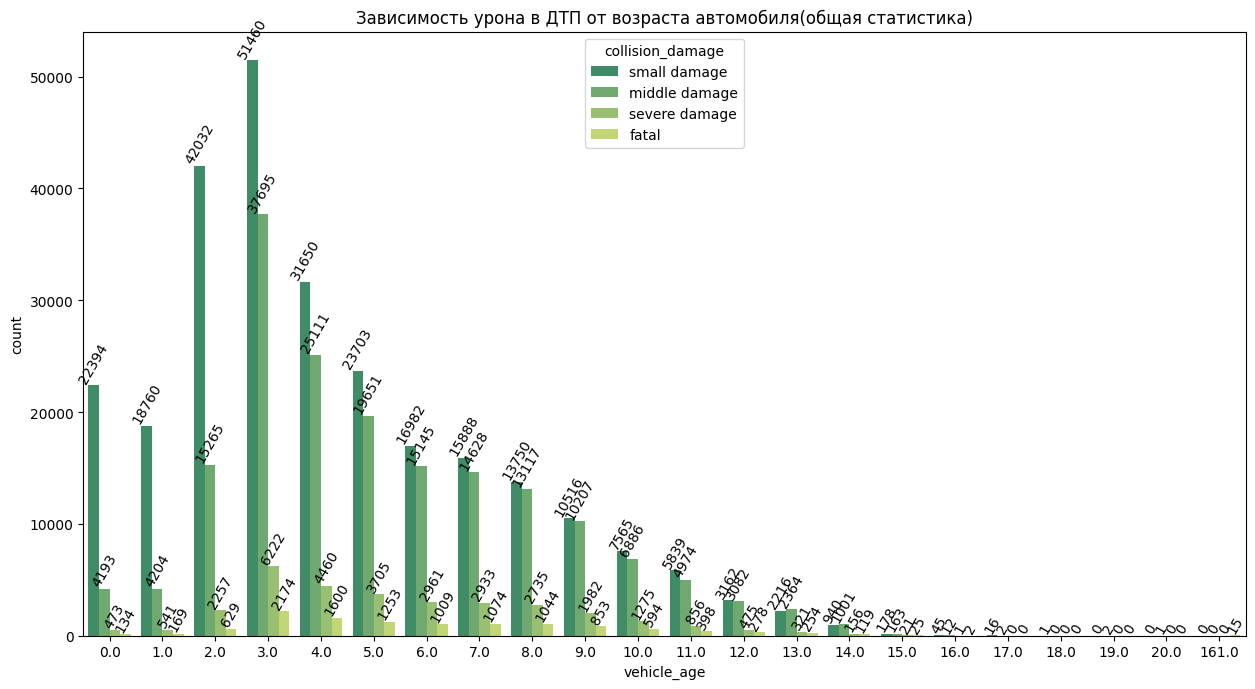

In [24]:
q7 = '''SELECT collision_damage, vehicle_age
        FROM (SELECT * FROM parties WHERE party_type='car') AS p
             JOIN vehicles AS v USING(case_id, party_number)
             JOIN (SELECT * FROM collisions WHERE collision_damage != 'scratch') AS c USING(case_id)
     '''
q7 = pd.read_sql_query(q7, con=engine)

fig, axes = plt.subplots(dpi=100, figsize=(15,8))
axes.set_title('Зависимость урона в ДТП от возраста автомобиля(общая статистика)')
ax = sns.countplot(x='vehicle_age', data=q7, hue='collision_damage', ax=axes, palette='summer')
for i in ax.containers:
    ax.bar_label(i, rotation=60);

**Выводы**
- картина для всех категорий авто примерно одинаковая.

**Зависимость вины в ДТП от погодных условий.**

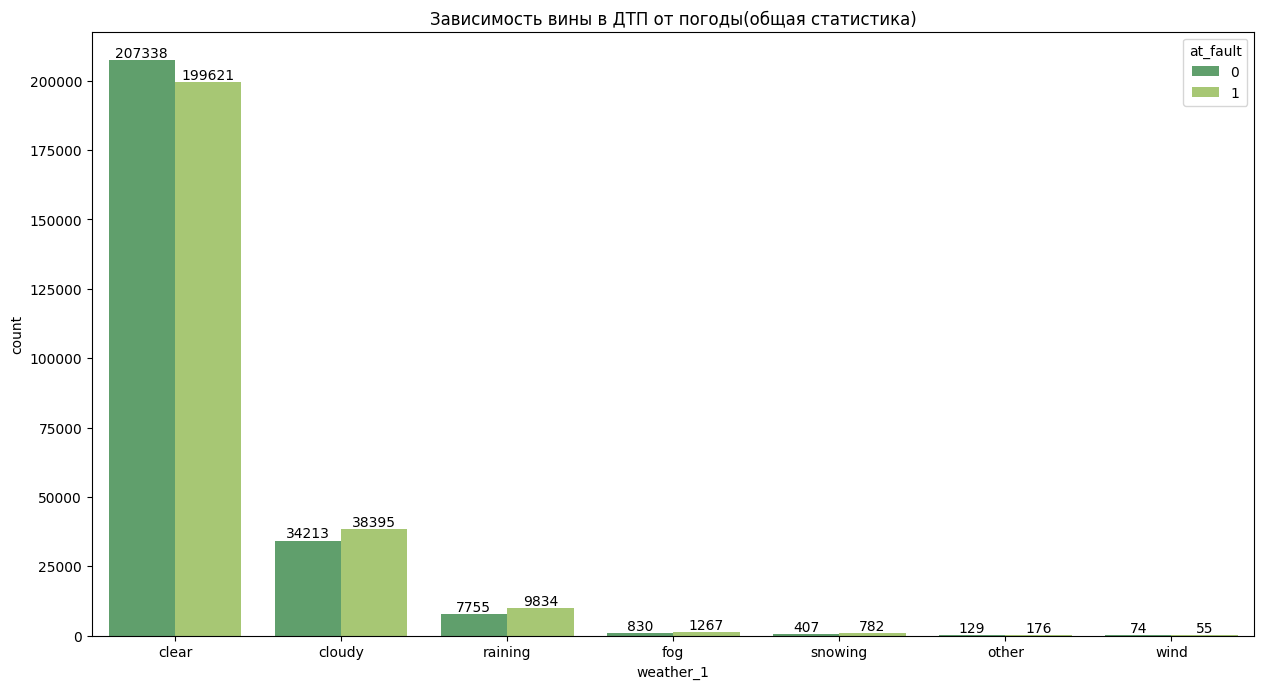

In [25]:
q8 = '''SELECT weather_1, at_fault
        FROM (SELECT * FROM parties WHERE party_type='car') AS p
             JOIN vehicles AS v USING(case_id, party_number)
             JOIN (SELECT * FROM collisions WHERE collision_damage != 'scratch') AS c USING(case_id)
     '''
q8 = pd.read_sql_query(q8, con=engine)

fig, axes = plt.subplots(dpi=100, figsize=(15,8))
axes.set_title('Зависимость вины в ДТП от погоды(общая статистика)')
ax = sns.countplot(x='weather_1', data=q8, hue='at_fault', ax=axes, palette='summer')
for i in ax.containers:
    ax.bar_label(i,);

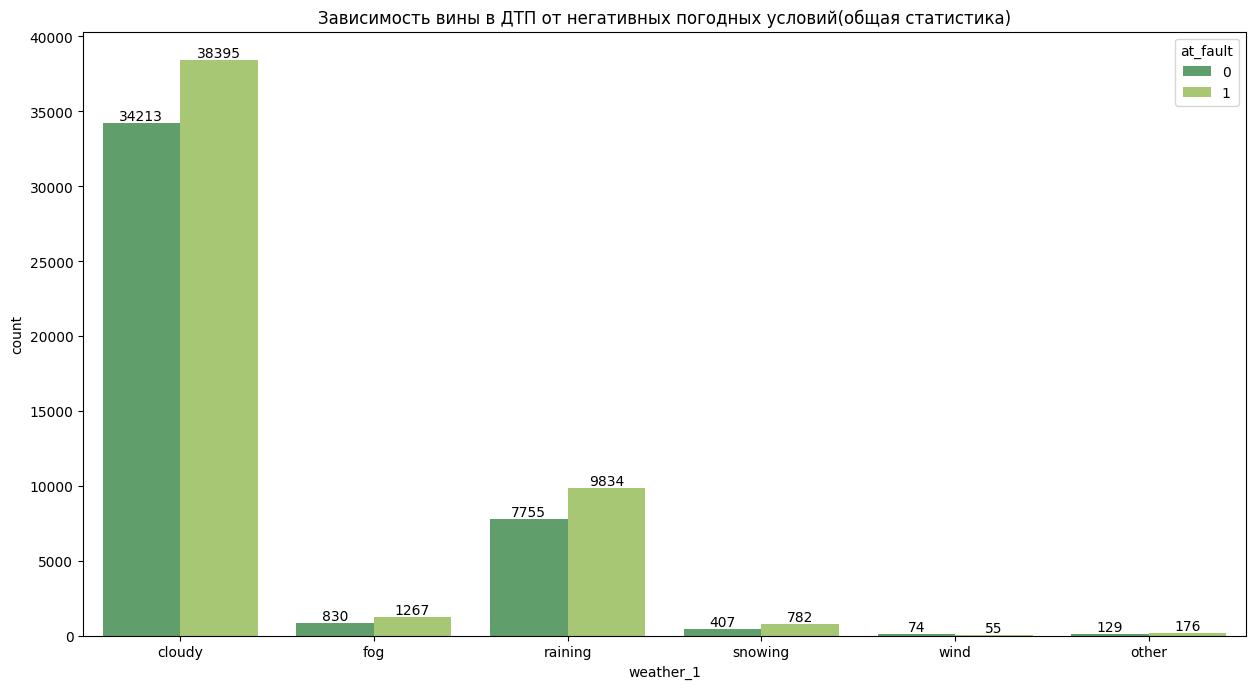

In [26]:
q9 = '''SELECT weather_1, at_fault
        FROM (SELECT * FROM parties WHERE party_type='car') AS p
             JOIN vehicles AS v USING(case_id, party_number)
             JOIN (SELECT * FROM collisions WHERE collision_damage != 'scratch') AS c USING(case_id)
        WHERE weather_1 != 'clear'
     '''
q9 = pd.read_sql_query(q9, con=engine)

fig, axes = plt.subplots(dpi=100, figsize=(15,8))
axes.set_title('Зависимость вины в ДТП от негативных погодных условий(общая статистика)')
ax = sns.countplot(x='weather_1', data=q9, hue='at_fault', ax=axes, palette='summer')
for i in ax.containers:
    ax.bar_label(i,);

**Выводы**
- любые негативные погодные условия являются фактором, кторый заставляет водителей чаще совершать ДТП.

**Зависимость вины в ДТП от оборудования авто**

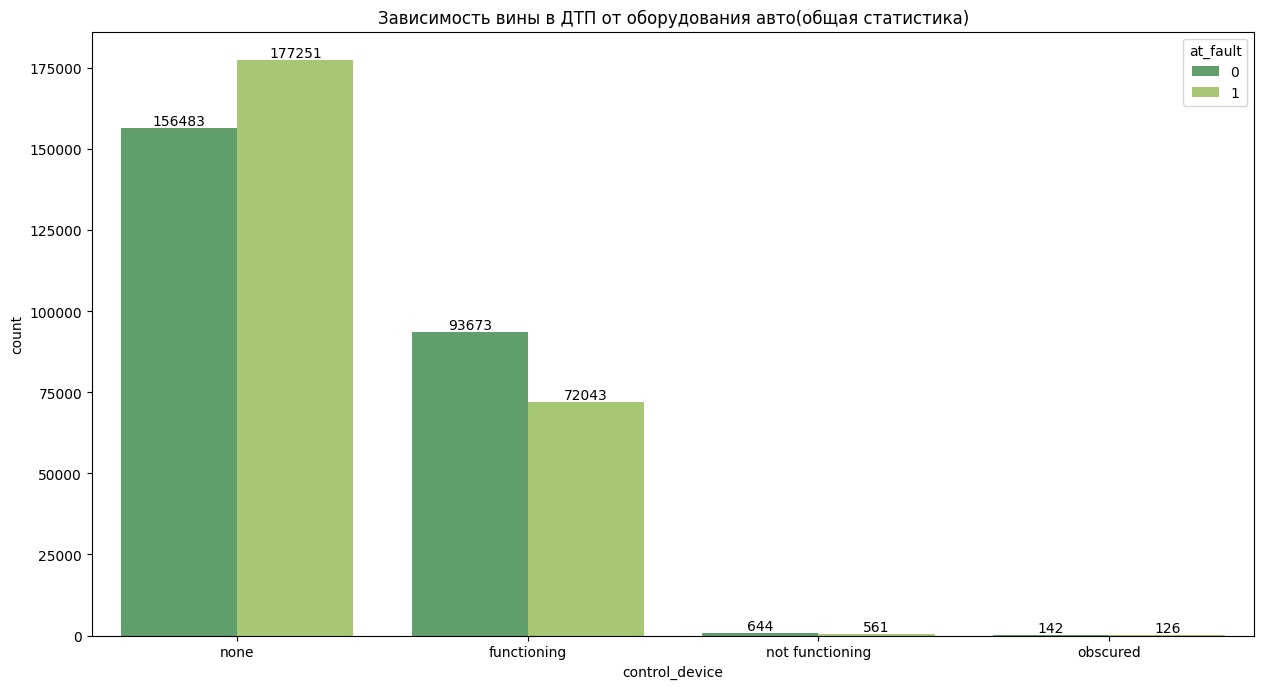

In [27]:
q10 = '''SELECT control_device, at_fault
        FROM (SELECT * FROM parties WHERE party_type='car') AS p
             JOIN vehicles AS v USING(case_id, party_number)
             JOIN (SELECT * FROM collisions WHERE collision_damage != 'scratch') AS c USING(case_id)
     '''
q10 = pd.read_sql_query(q10, con=engine)

fig, axes = plt.subplots(dpi=100, figsize=(15,8))
axes.set_title('Зависимость вины в ДТП от оборудования авто(общая статистика)')
ax = sns.countplot(x='control_device', data=q10, hue='at_fault', ax=axes, palette='summer')
for i in ax.containers:
    ax.bar_label(i,);

**Выводы**
- судя по графику функционирующие устройства контоля снижают риск ДПТ со стороны водителя.

**Зависимость вины в ДТП от объекта столкновения(общая статистика)**

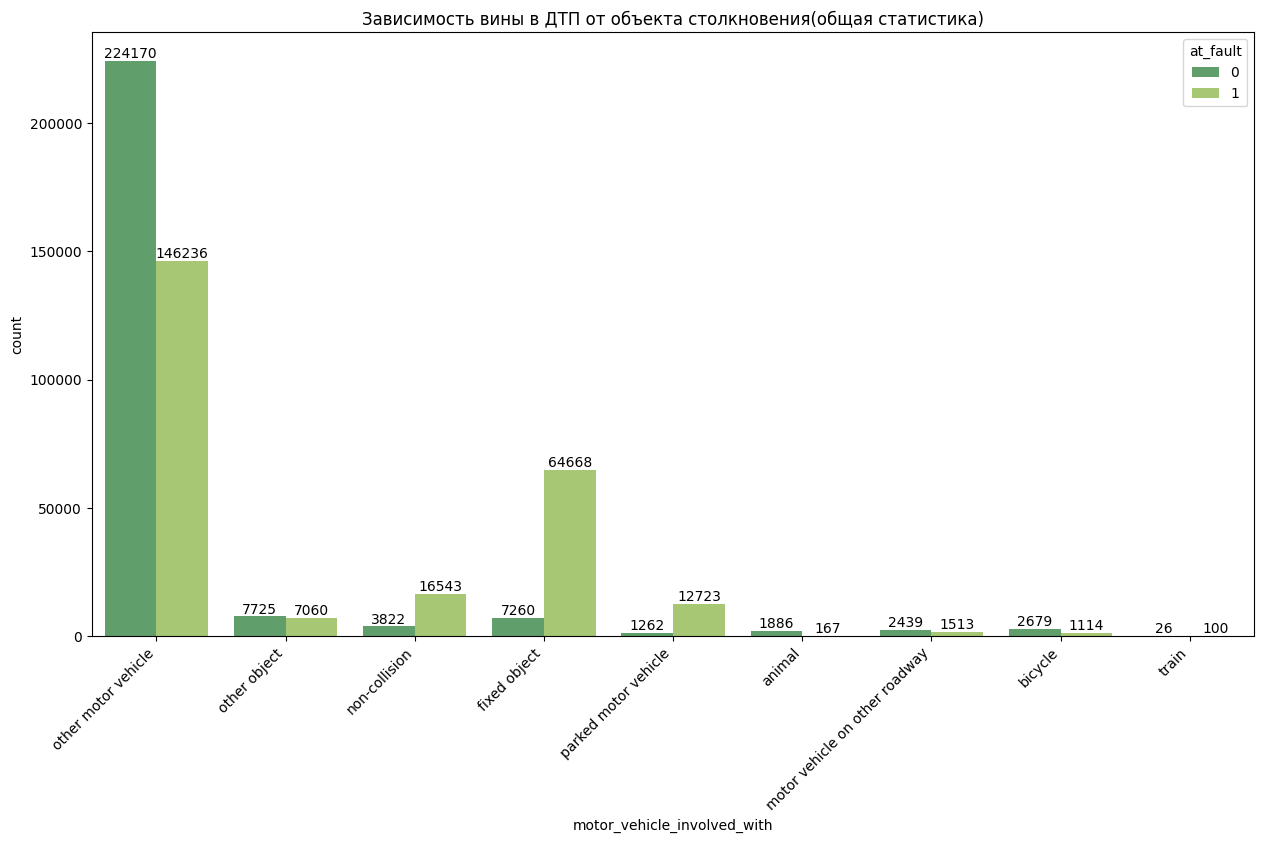

In [28]:
q11 = '''SELECT motor_vehicle_involved_with, at_fault
        FROM (SELECT * FROM parties WHERE party_type='car') AS p
             JOIN vehicles AS v USING(case_id, party_number)
             JOIN (SELECT * FROM collisions WHERE collision_damage != 'scratch') AS c USING(case_id)
     '''
q11 = pd.read_sql_query(q11, con=engine)

fig, axes = plt.subplots(dpi=100, figsize=(15,8))
axes.set_title('Зависимость вины в ДТП от объекта столкновения(общая статистика)')
ax = sns.countplot(x='motor_vehicle_involved_with', data=q11, hue='at_fault', ax=axes, palette='summer')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
for i in ax.containers:
    ax.bar_label(i,);

**Выводы**
- при столнковении с неподвижным объектом вина обычно лежит на водите, что логично,
- при столкновении с движущимся объектом, чаще виновата вторая сторона ДТП.

## Создайте модель для оценки водительского риска

Для создания модели выбираем проишествия, где ущерб больше чем царапина, участник - автомобиль и год проишествия 2012.

**Отбираем необхрдимые для моделирования признаки**

 - at_fault - целевой признак, 
 - party_sobriety - степень опьянения водителя, существенный признак + возможно выяснить до начала поездки,
 - cellphone_in_use - возможность разговаривать по громкой связи стоит рассмотреть,
 - vehicle_transmission - тип КПП важный признак, оставим,
 - vehicle_age - возраст а/м по условию необходимио оставить
 - county_location, direction - т.к. суть исследования прогноз возможности ДПТ для локации, то эти признаки необходимы, 
 - intersection -  неколько относительный признак, но наличие сложных перекрестков на пути стоит учесть,
 -  weather_1, location_type, road_surface, road_condition_1, lighting - сотояние лорог, освещение, погода влияют на количетво ДТП оставляем,
 - control_device, collision_date, collision_time - в предварительном анализе видели, что эти признаки влияют на количтсво ДПТ и вину, оставляем.

**Убираем лишние для модели признаки:**
 - 'case_id','id','party_number','party_type','party_count' - не несут никакой полезной информации,
 - 'insurance_premium' - выплачивает после ДТП? не можем знать заранее,
 - 'vehicle_type' - тип машины вряд ли может влиять на частоту ДПТ или вину при них, это даже не марка,
 - 'party_drug_physical' - интересный признак, но его никак не возможно определить заранее, тест на вещества сдается после и в мед.учереждении,
 - 'county_city_location' - локацию отражаюот признаки 'county_city_location' и 'direction', от этого избавимся.
 - 'distance', 'primary_collision_factor','type_of_collision','collision_damage', 'pcf_violation_category', 'motor_vehicle_involved_with' - все эти признаки мы можем определить лишь по факту происшествия, заранее их предвидеть невозможно,
 - 'party_sobriety' как допусловие исключаем степень опьянения. 


In [29]:
main_query = '''SELECT at_fault,
                       cellphone_in_use,
                       vehicle_transmission,
                       vehicle_age,
                       county_location,
                       direction, 
                       intersection, 
                       weather_1, 
                       location_type,
                       road_surface, 
                       road_condition_1,
                       lighting, 
                       control_device, 
                       collision_date, 
                       collision_time
                FROM (SELECT * FROM parties WHERE party_type='car') AS p
                    JOIN vehicles AS v USING(case_id, party_number)
                    JOIN (SELECT *
                          FROM collisions
                          WHERE collision_damage != 'scratch' 
                                AND EXTRACT(YEAR from collision_date) = 2012) AS c USING(case_id)  
              '''
main_query = pd.read_sql_query(main_query, con=engine)
main_query.sample(5)

,at_fault,cellphone_in_use,vehicle_transmission,vehicle_age,county_location,direction,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
49115,0,0.0,manual,3.0,solano,west,0.0,clear,highway,dry,normal,daylight,none,2012-06-01,09:30:00
9751,0,0.0,manual,8.0,lake,south,0.0,clear,highway,dry,normal,dark with no street lights,none,2012-01-14,19:58:00
39044,1,NaN,manual,3.0,san diego,None,0.0,cloudy,None,dry,normal,daylight,none,2012-05-17,18:30:00
53962,1,0.0,manual,4.0,imperial,west,0.0,clear,highway,dry,normal,dark with no street lights,none,2012-01-01,23:05:00
7952,1,0.0,manual,2.0,los angeles,None,1.0,clear,None,dry,normal,dark with street lights,functioning,2012-02-17,19:35:00


In [30]:
main_query.columns

Index(['at_fault', 'cellphone_in_use', 'vehicle_transmission', 'vehicle_age',
       'county_location', 'direction', 'intersection', 'weather_1',
       'location_type', 'road_surface', 'road_condition_1', 'lighting',
       'control_device', 'collision_date', 'collision_time'],
      dtype='object')

In [31]:
main_query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              56248 non-null  int64  
 1   cellphone_in_use      51777 non-null  float64
 2   vehicle_transmission  55389 non-null  object 
 3   vehicle_age           54554 non-null  float64
 4   county_location       56248 non-null  object 
 5   direction             43230 non-null  object 
 6   intersection          56073 non-null  float64
 7   weather_1             56080 non-null  object 
 8   location_type         25932 non-null  object 
 9   road_surface          55900 non-null  object 
 10  road_condition_1      55999 non-null  object 
 11  lighting              56094 non-null  object 
 12  control_device        56033 non-null  object 
 13  collision_date        56248 non-null  object 
 14  collision_time        56160 non-null  object 
dtypes: float64(3), int6

                                             |          | [  0%]   00:00 -> (? left)


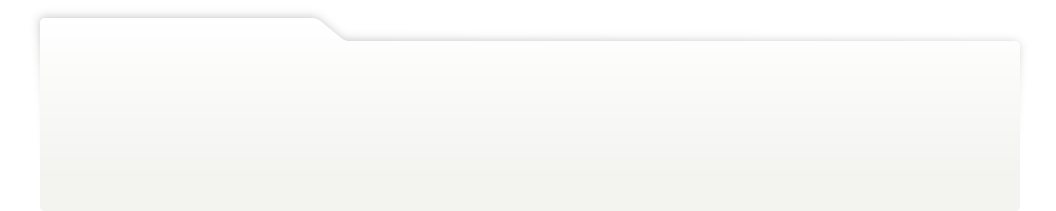
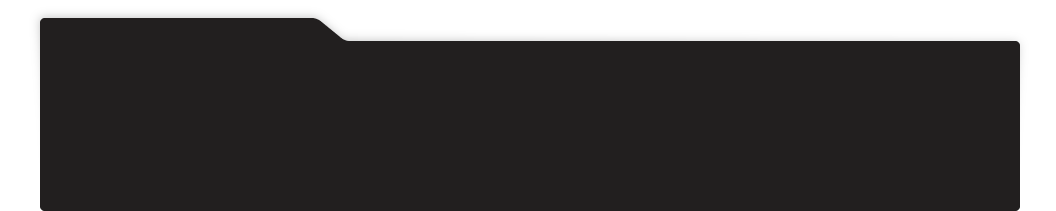
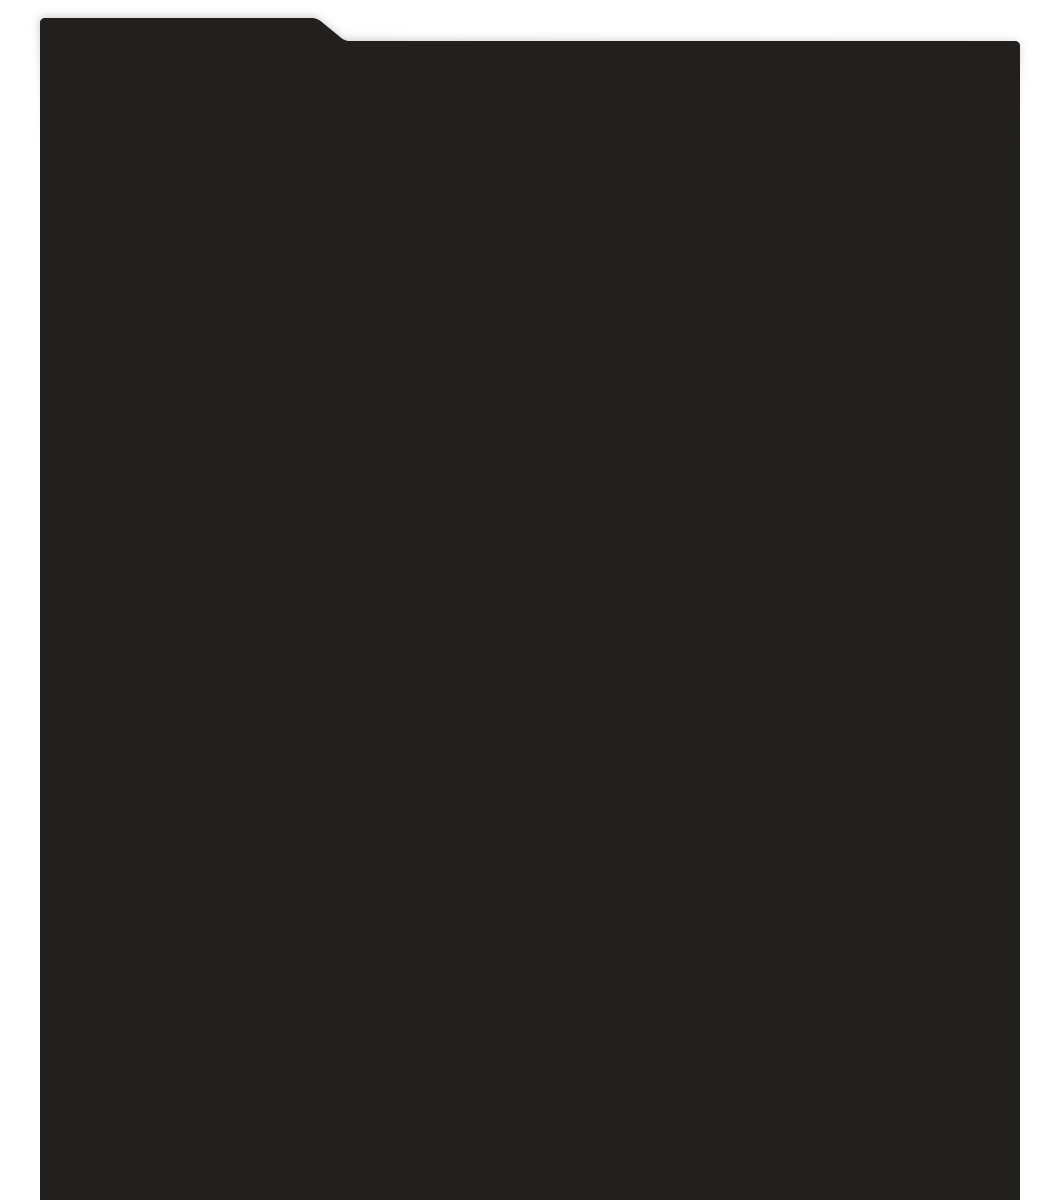
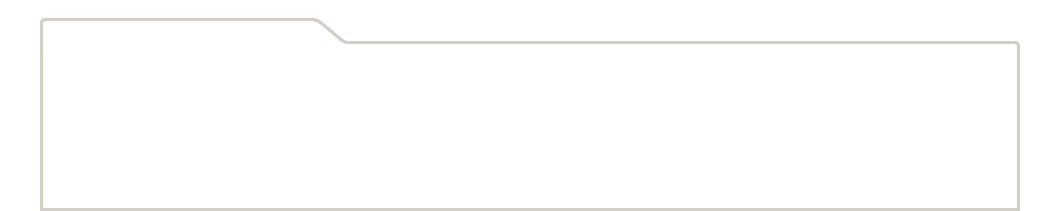
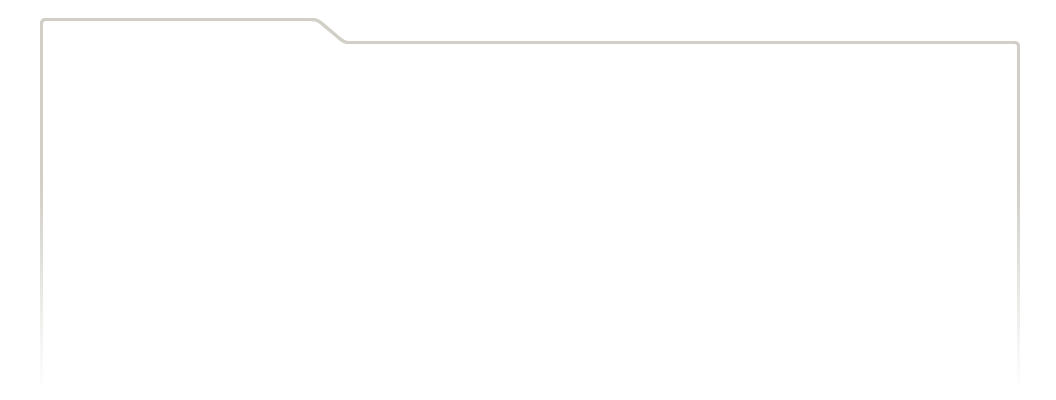
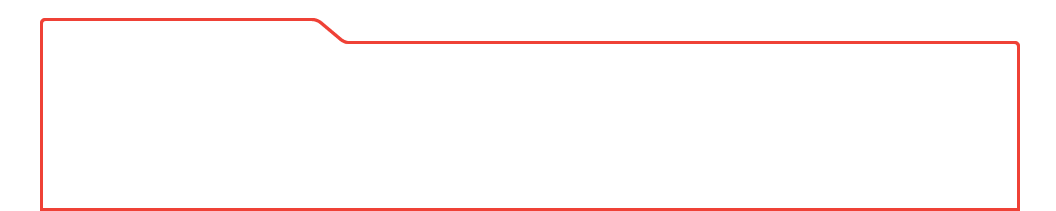
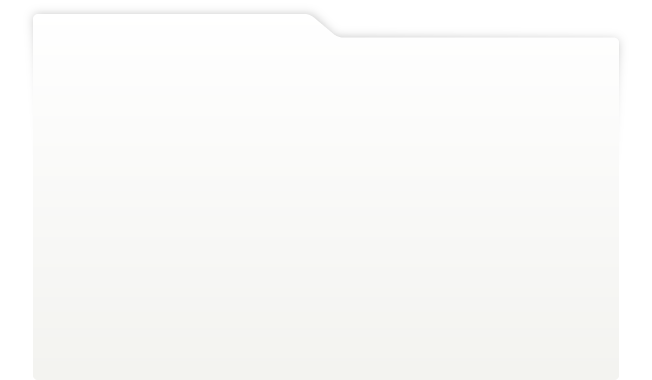
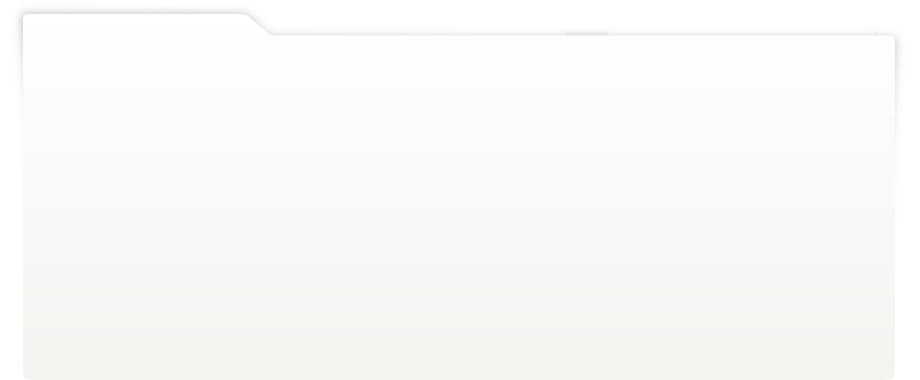
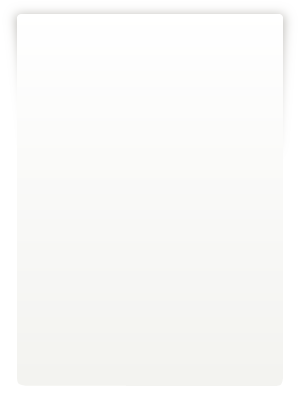
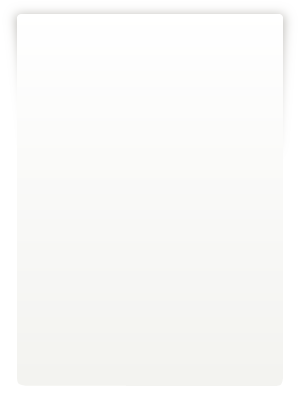
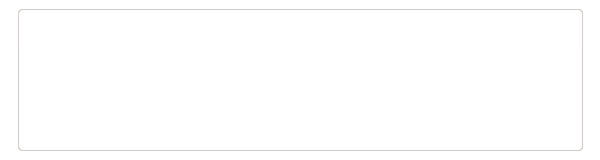
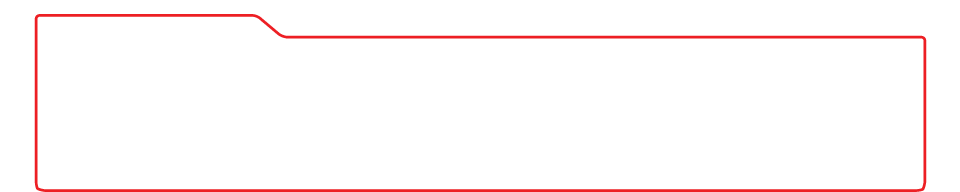
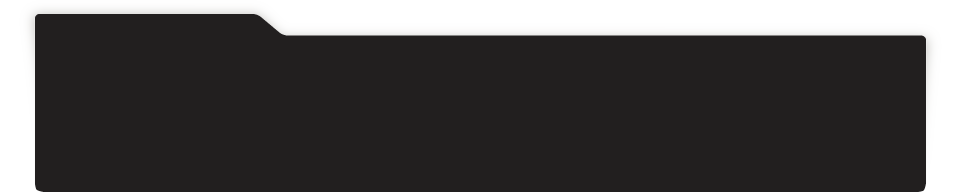
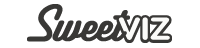
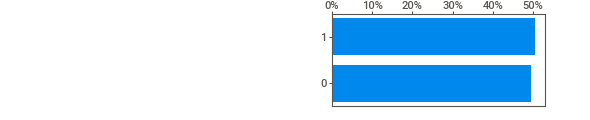
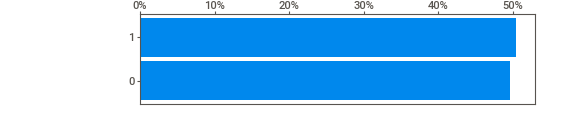
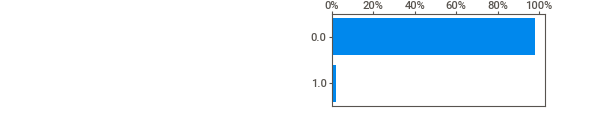
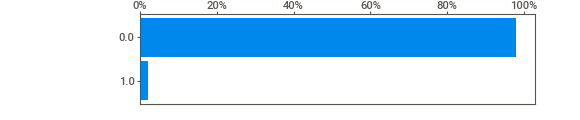
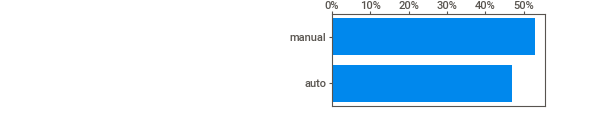
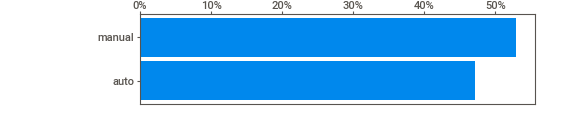
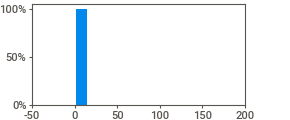
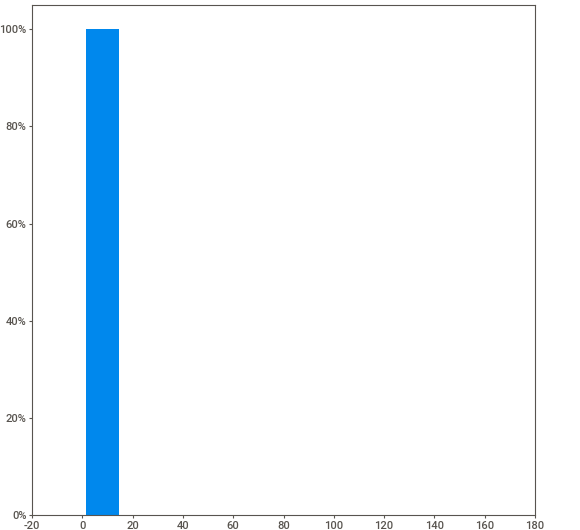
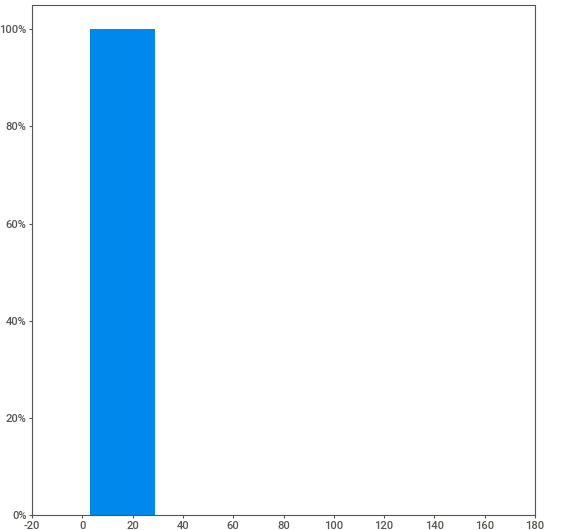
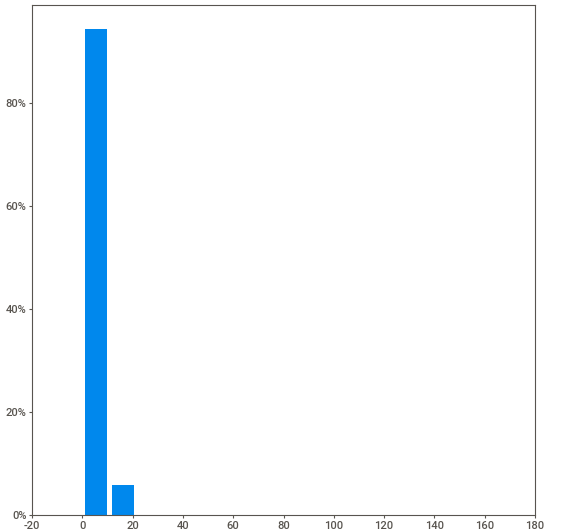
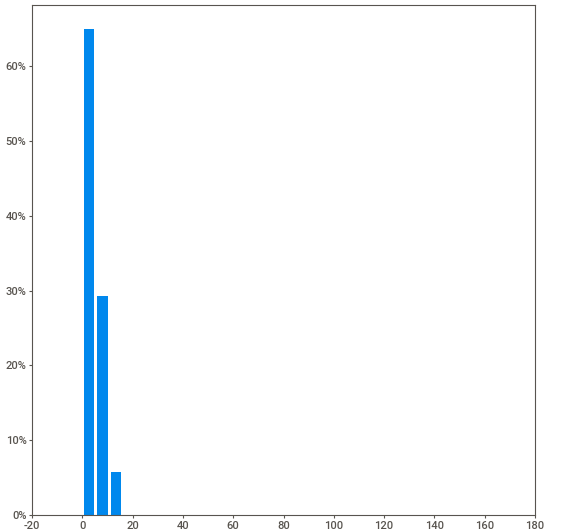
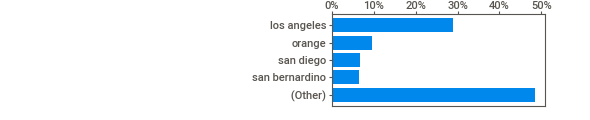
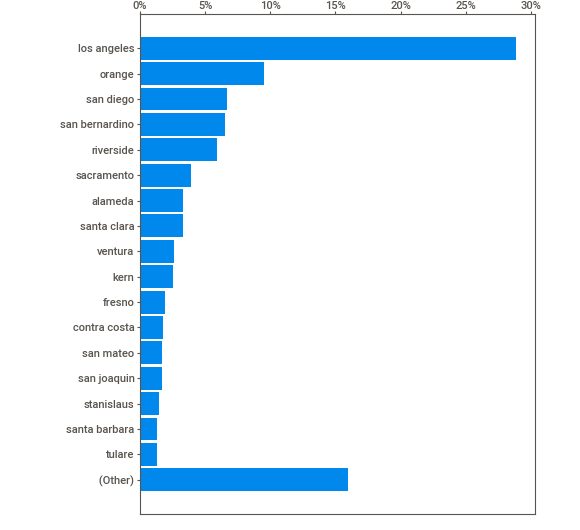
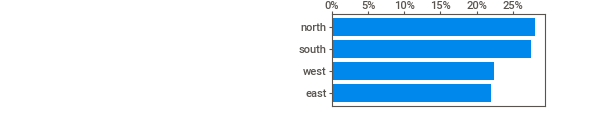
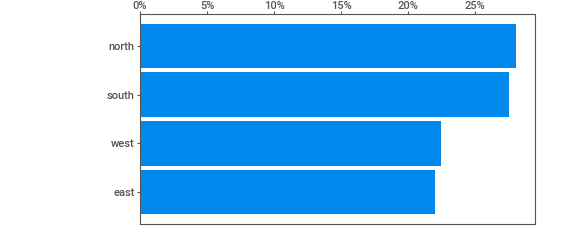
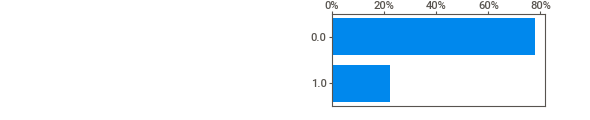
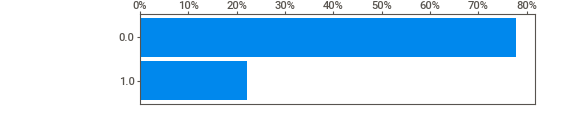
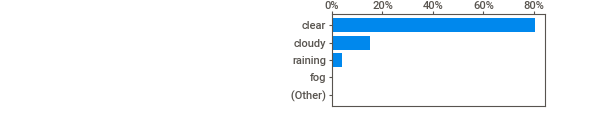
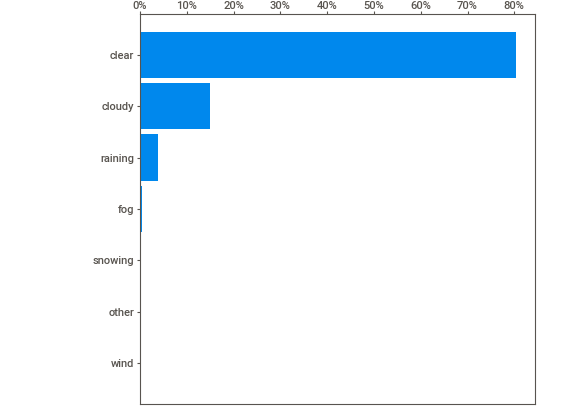
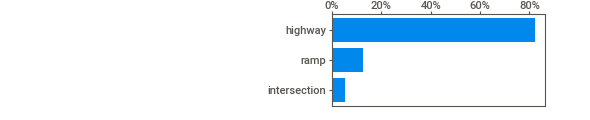
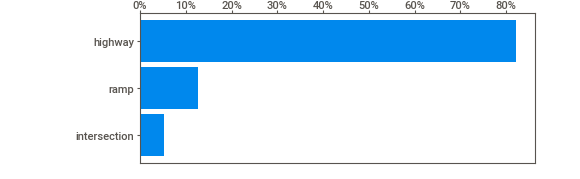
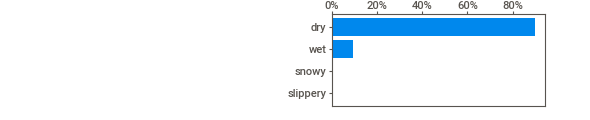
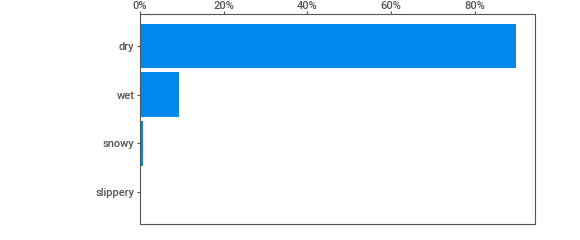
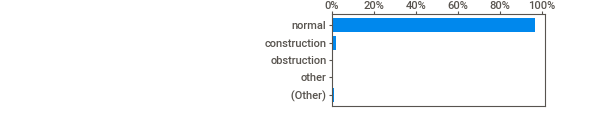
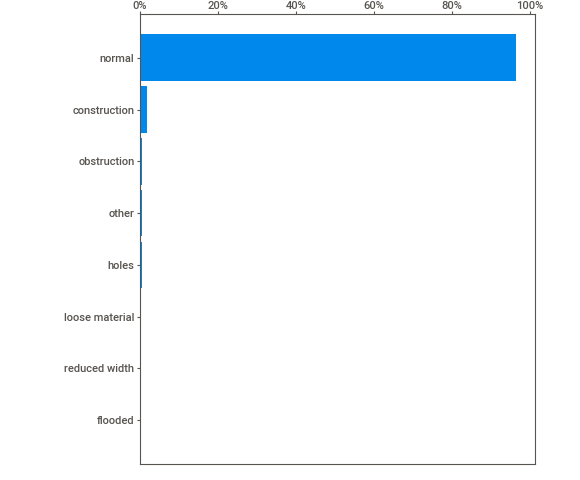
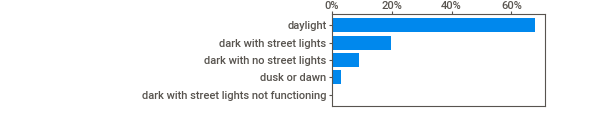
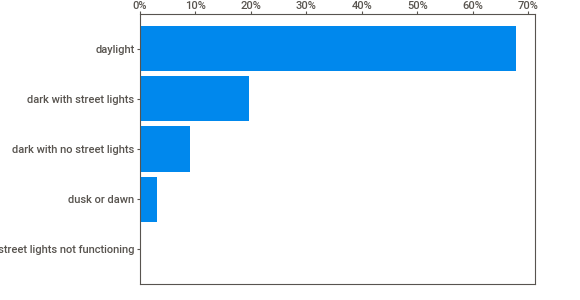
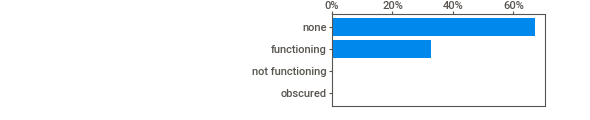
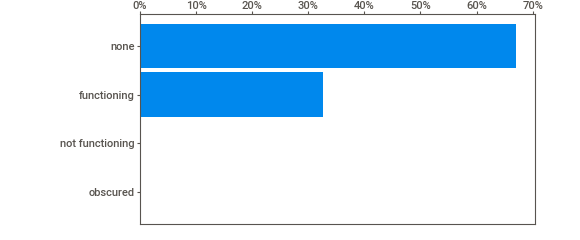
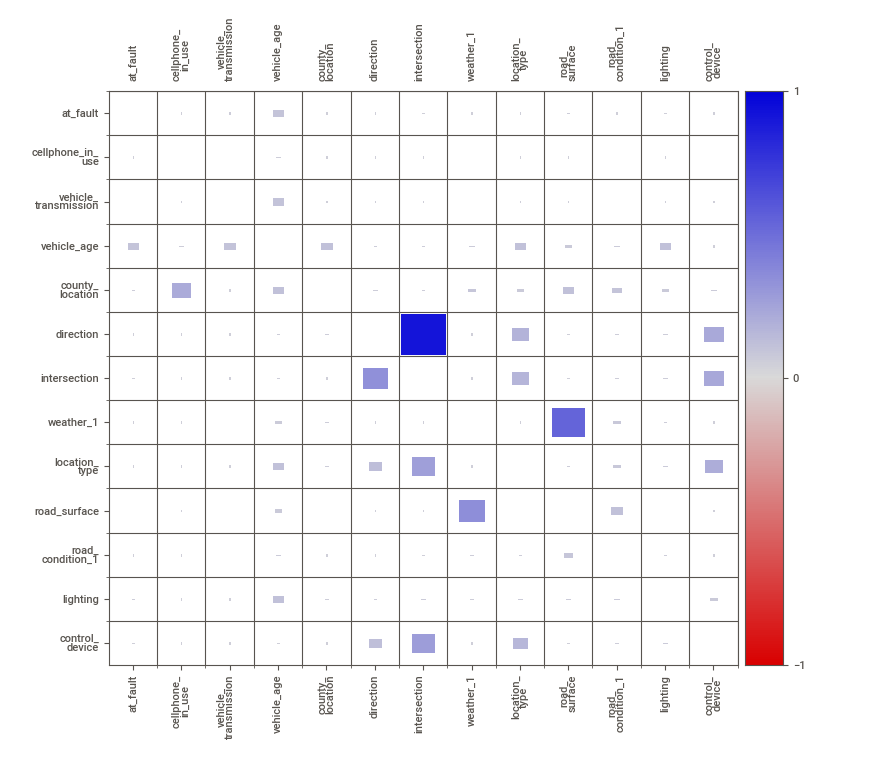
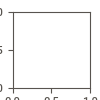

In [32]:
report = sv.analyze([main_query, "Данные о ДПТ"])
report.show_notebook()

**Промежуточные выводы**
 - at_fault - целевой признак, пропущенных значений нет, соотношение категорий равномерное;
 
 - cellphone_in_use - булевый признак, менее 1% пропусков, неравномерное соотношение категорий 92% к 8%,
 - vehicle_transmission - категориальный признак, 2 категории, менее 1% пропусков, равномерное соотношение категорий,
 - vehicle_age - количественный признак, пропущено 3% значений, непохожее на нормальное распределение, большая часть значений равна 3, общий диапазон от 0 до 19, но присутствуют выбросы(несколько значений равны 161)
 - county_location - категориальный признак, 58 уникальных значений, нет пропусков, самое распростаненное значение los sngeles(29%), частота прочих значений в диапазоне от 1 до 10%,
 - direction - категориальный признак, 4 категории, 23% пропущенных значений, примерно равное распределение категорий,
 - intersection - булевый признак, около 1% пропусков, чаще встречается значение 0(78%),
 - weather_1 - категориальный признак, 7 уникальных значений, 1% пропусков, самое распростаненное значение clear(80%), частота прочих значений в диапазоне от 1 до 15%,
 - location_type - категориальный признак, 3 уникальных значения, 54% пропусков, самое распростаненное значение higway (82%), частота прочих значений в диапазоне от 5 до 13%,
 - road_surface - категориальный признак, 4 уникальных значения, 1% пропусков, самое распростаненное значение dry (90%), частота прочих значений в диапазоне от 1 до 9%,
 - road_condition_1 - категориальный признак, 8 уникальных значения, 1% пропусков, самое распростаненное значение normal (97%), частота прочих значений в диапазоне от 1 до 2%,
 - lighting - категориальный признак, 5 уникальных значений, 1% пропусков, самое распростаненное значение daylight (68%), частота прочих значений в диапазоне от 1 до 20%,
 - control_device - категориальный признак, 4 уникальных значения, 1% пропусков, самое распростаненное значение none (67%), частота прочих значений в диапазоне от 1 до 33%,
 - collision_date, collision_time - признаки формата text,  без пропусков, переведем их в двльнейшем в формат даты и выделим необходимые диапазоны.
 

Для дальнейшего исследования заполним пропуски, обьедимин категории некоторых признаков и упростим часть признаков до булевых.
 

### Подготовка данных

Рассмотрим признаки конкретнее.

In [33]:
#поставим заглушку в типе коробки передач
main_query.vehicle_transmission.fillna('unknown', inplace=True)
#поставим заглушку в типе локации
main_query.location_type.fillna('unknown', inplace=True)
#поставим заглушку в направлении
main_query.direction.fillna('unknown', inplace=True)

In [34]:
#заполиним пропуски касаемые использования телефона 0
main_query.cellphone_in_use.fillna(0, inplace=True)

In [35]:
main_query[main_query.vehicle_age>20]

,at_fault,cellphone_in_use,vehicle_transmission,vehicle_age,county_location,direction,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
26721,1,0.0,manual,161.0,los angeles,north,0.0,clear,unknown,dry,normal,daylight,none,2012-06-20,11:45:00
29952,0,0.0,manual,161.0,los angeles,unknown,1.0,clear,ramp,dry,normal,dusk or dawn,functioning,2012-12-05,05:55:00


Ну это все-таки выброс, удалим его после разбиения на выборки. Старовато для каршеринга.

In [36]:
#оклоло процента пропусков в перекрестак посчитаем как отсутствие перекрестка
main_query.intersection.fillna(0, inplace=True)

Погоду сведем к моменту ухудшения видимости - есть/нет. Ранее при анализе, мы видели что все негативные погодные условия влияют примерно одинаково.

In [37]:
neg_weather = ['raining', 'fog', 'snowing', 'wind', 'other']

In [38]:
main_query['neg_weather'] = main_query['weather_1'].apply(lambda x: 1 if x in neg_weather else 0)

Рассмотривал вариант свести состояние дороги к булевому значению, но это негативно отражается на модели. Оставим так.

In [39]:
# заполним основным значением
main_query.road_surface.fillna('dry', inplace=True)
main_query.road_condition_1.fillna('normal', inplace= True)

Объединим две категории освещения - если фонари не горят, не имеет значения есть ли они. Пропуски заменим самым частым значением.

In [40]:
main_query.lighting.fillna('daylight', inplace=True)
main_query.lighting.replace('dark with street lights not functioning', 'dark with no street lights', inplace=True)
main_query.lighting.value_counts()

daylight                      38218
dark with street lights       11017
dark with no street lights     5244
dusk or dawn                   1769
Name: lighting, dtype: int64

Наличие прибора контороля влияет на вину в ДТП, как ранее мы видели в анализе данных,но лишь наличие, поэтому сведем признак к булевому.

In [41]:
main_query['control_device_func'] = main_query['control_device'].apply(lambda x: 1 if x=='functioning' else 0)

Из временных колонок извлечем месяц и час.

In [42]:
main_query['month'] = pd.to_datetime(main_query['collision_date'])
main_query['month'] = main_query['month'].dt.month

In [43]:
main_query['collision_time'].fillna('00:00:00', inplace=True)
main_query['collision_hour'] = pd.to_datetime(main_query['collision_time'], format='%H:%M:%S')
main_query['collision_hour'] = main_query['collision_hour'].apply(lambda x: x.hour)

In [44]:
main_query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              56248 non-null  int64  
 1   cellphone_in_use      56248 non-null  float64
 2   vehicle_transmission  56248 non-null  object 
 3   vehicle_age           54554 non-null  float64
 4   county_location       56248 non-null  object 
 5   direction             56248 non-null  object 
 6   intersection          56248 non-null  float64
 7   weather_1             56080 non-null  object 
 8   location_type         56248 non-null  object 
 9   road_surface          56248 non-null  object 
 10  road_condition_1      56248 non-null  object 
 11  lighting              56248 non-null  object 
 12  control_device        56033 non-null  object 
 13  collision_date        56248 non-null  object 
 14  collision_time        56248 non-null  object 
 15  neg_weather        

Итогова выборка

In [45]:
df_main = main_query.drop(columns=[#'party_sobriety',
                                  'weather_1',
                                  'control_device',
                                  'collision_date',
                                  'collision_time',
                                  ])

In [46]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              56248 non-null  int64  
 1   cellphone_in_use      56248 non-null  float64
 2   vehicle_transmission  56248 non-null  object 
 3   vehicle_age           54554 non-null  float64
 4   county_location       56248 non-null  object 
 5   direction             56248 non-null  object 
 6   intersection          56248 non-null  float64
 7   location_type         56248 non-null  object 
 8   road_surface          56248 non-null  object 
 9   road_condition_1      56248 non-null  object 
 10  lighting              56248 non-null  object 
 11  neg_weather           56248 non-null  int64  
 12  control_device_func   56248 non-null  int64  
 13  month                 56248 non-null  int64  
 14  collision_hour        56248 non-null  int64  
dtypes: float64(3), int6

18 признаков обработаны, возраст автомобиля поправим после разбиения на выборки. Заполим его самым распространенным знчением.

### Корреляционный анализ

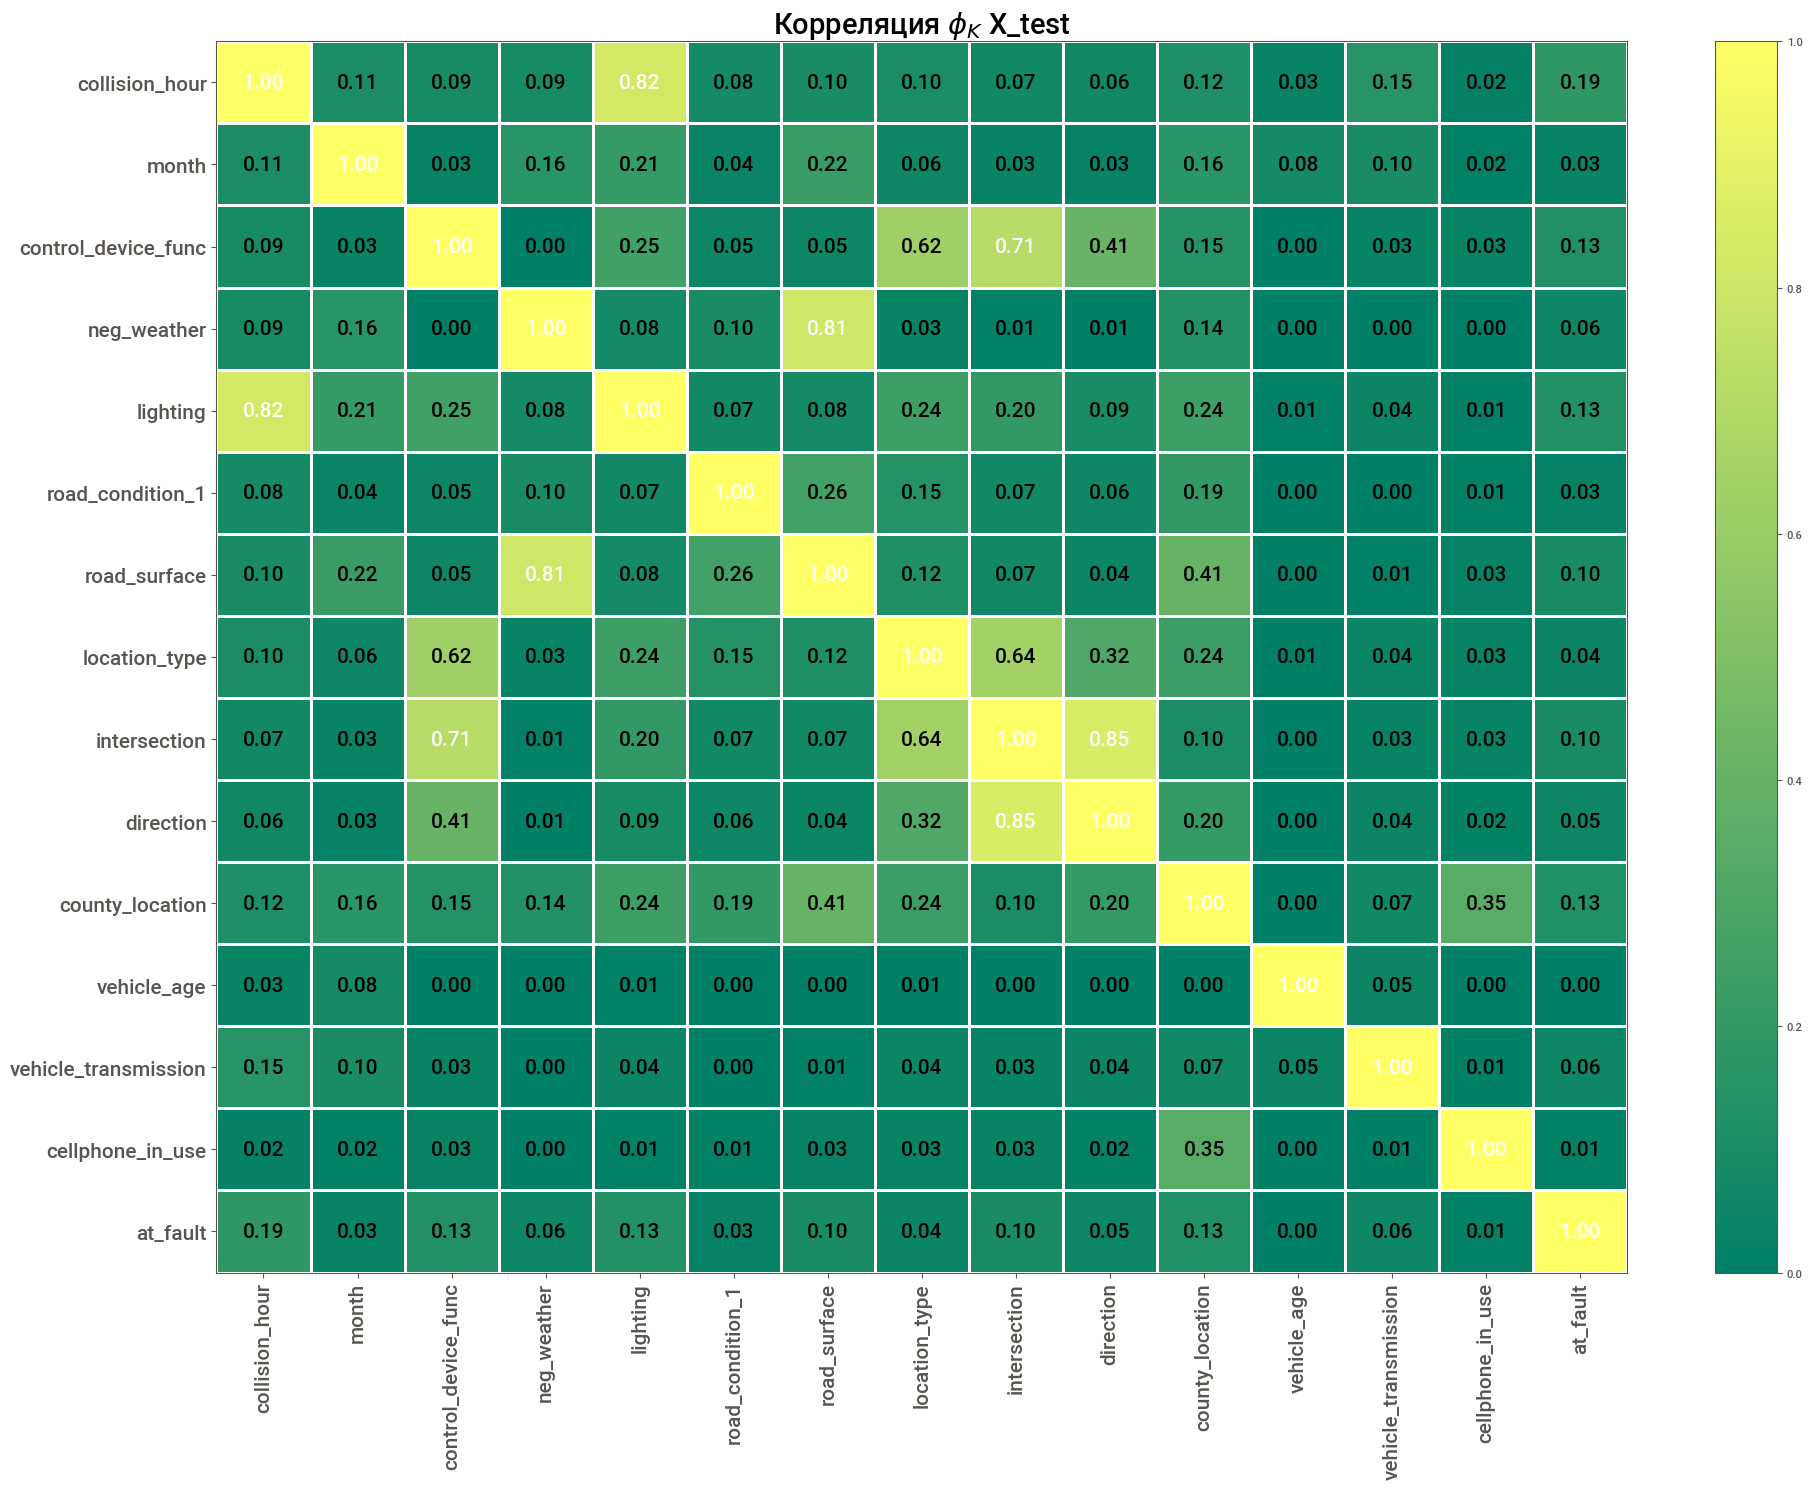

In [47]:
phik_overview = (
    df_main
    .phik_matrix(verbose=False, interval_cols=['vehicle_age']))

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='summer',
    title=r'Корреляция $\phi_K$ X_test',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Мультиколлинеарности не наблюдается. А вот зависимость целевого признака от 'pcf_violation_category' и 'motor_vehicle_involved_with' весьма высокая. Учтем это для дальнейшего исследования.

Создадим датасет для моделирования без спорных признаков и утечки данных.

### Подготовка к моделированию

In [48]:
X_train, X_test, y_train, y_test = train_test_split(df_main.drop('at_fault', axis = 1),
                                                    df_main['at_fault'],
                                                    test_size=TEST_SIZE,
                                                    stratify=df_main['at_fault'],
                                                    random_state=RANDOM_STATE)

#проверка размерности
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(42186, 14) (14062, 14) (42186,) (14062,)


In [49]:
# дополнительно обработаем возраст авто на тренировочной выборке
X_train.vehicle_age.fillna(3.0, inplace=True)
d_ind = X_train[X_train['vehicle_age'] >20]. index.to_list()
X_train[X_train['vehicle_age']>20]

,cellphone_in_use,vehicle_transmission,vehicle_age,county_location,direction,intersection,location_type,road_surface,road_condition_1,lighting,neg_weather,control_device_func,month,collision_hour
26721,0.0,manual,161.0,los angeles,north,0.0,unknown,dry,normal,daylight,0,0,6,11
29952,0.0,manual,161.0,los angeles,unknown,1.0,ramp,dry,normal,dusk or dawn,0,1,12,5


In [50]:
X_train.drop(index=d_ind, inplace=True)
X_train.vehicle_age.isna().sum()

0

In [51]:
y_train = y_train.drop(index=d_ind)

In [52]:
print(X_train.shape, y_train.shape)

(42184, 14) (42184,)


In [53]:
X_train.columns


Index(['cellphone_in_use', 'vehicle_transmission', 'vehicle_age',
       'county_location', 'direction', 'intersection', 'location_type',
       'road_surface', 'road_condition_1', 'lighting', 'neg_weather',
       'control_device_func', 'month', 'collision_hour'],
      dtype='object')

In [54]:
# категориальные признаки
cat_col = [#'sobriety',
           'vehicle_transmission',
           'county_location',
           'direction',
           'location_type',
           'road_surface',
           'road_condition_1',
           'lighting',
           'month',
           'collision_hour'
          ]

### Моделирование

Выберем метрику для оценки модели. 
 - самым простым способом оценить качество модели является Accuracy или точность, которая отражает долю правильно спрогнозированных классов среди всех образцов;
 - Precision характеризует долю правильно предсказанных положительных классов среди всех образцов, которые модель спрогнозировала как положительный класс;
 - True Positive Rate(Recall) отражает долю правильно предсказанных положительных классов среди всех реальных положительных образцов;
 - F1-score представляет собой гармоническое среднее между Precision и Recall, обеспечивая между ними баланс.
 
 В целом у нас нет дисбаланса классов, и по логике исследования класс 1 интересует нас больше всего, поэтому логично будет остановиться на recall или F1. Остановимся на более общей метрике F1 при кросс валидации, а на тесте посмотрим и все остальные, на графиках и матрицах.

Рассмотрим модели логистической регрессии, леса и бустинговую(catboost).

In [55]:
num_columns = ['vehicle_age']
ohe_columns = cat_col.copy()

#### LogisticRegression

In [56]:
# создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe_log = Pipeline(
    [('simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output =False))
    ]
)
# создаём общий пайплайн для подготовки данных
data_preprocessor_log = ColumnTransformer(
    [('ohe', ohe_pipe_log, ohe_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough', force_int_remainder_cols=False
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_fin_log = Pipeline([
    ('preprocessor', data_preprocessor_log),
    ('models', LogisticRegression())
])

In [57]:
#DF для сравнений
df_scoring=pd.DataFrame(columns=['model_name', 'accuracy_train'])

In [58]:
param_log=[    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE
        )],
        'models__solver': ['liblinear'],
        'models__penalty': ['l1', 'l2'],
        'models__C': [1,2,3],
        'preprocessor__num': [StandardScaler()]
    },]

search_log = GridSearchCV(pipe_fin_log, param_log, cv=5, scoring='f1', verbose=1)

In [59]:
%%time
search_log.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 34.6 s, sys: 3.97 s, total: 38.5 s
Wall time: 38.9 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['vehicle_transmission',
                                                                          'county_loca...
                                                                          'road_surface',
                                                                          'road_condition_1',
                                                                          'lighting',
                                                                          'month',
                                                                          'collision_hour']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['vehicle_age'])])),
                                       ('models', LogisticRegression())]),
             param_grid=[{'models': [LogisticRegression(random_state=42)],
                          'models__C': [1, 2, 3],
                          'models__penalty': ['l1', 'l2'],
                          'models__solver': ['liblinear'],
                          'preprocessor__num': [StandardScaler()]}],
             scoring='f1', verbose=1)

In [60]:
best_log=search_log.best_estimator_
cross_params(search_log)

Парамерты лучшей модели {'models': LogisticRegression(random_state=42), 'models__C': 1, 'models__penalty': 'l1', 'models__solver': 'liblinear', 'preprocessor__num': StandardScaler()}
F1 с лучшими гиперпараметрами на кросс-валидации : 0.5709215096147042


,rank_test_score,mean_test_score,params,mean_fit_time
0,1,0.570922,"{'models': LogisticRegression(random_state=42), 'models__C': 1, 'models__penalty': 'l1', 'models__solver': 'liblinear', 'preprocessor__num': StandardScaler()}",1.326262
1,2,0.570307,"{'models': LogisticRegression(random_state=42), 'models__C': 1, 'models__penalty': 'l2', 'models__solver': 'liblinear', 'preprocessor__num': StandardScaler()}",0.765543
2,3,0.569742,"{'models': LogisticRegression(random_state=42), 'models__C': 2, 'models__penalty': 'l1', 'models__solver': 'liblinear', 'preprocessor__num': StandardScaler()}",1.385192
3,4,0.569717,"{'models': LogisticRegression(random_state=42), 'models__C': 2, 'models__penalty': 'l2', 'models__solver': 'liblinear', 'preprocessor__num': StandardScaler()}",0.754284
4,5,0.569485,"{'models': LogisticRegression(random_state=42), 'models__C': 3, 'models__penalty': 'l1', 'models__solver': 'liblinear', 'preprocessor__num': StandardScaler()}",1.444888


In [61]:
df_scoring.loc[len(df_scoring.index)]=('LogisticRegression', search_log.best_score_)

#### RandomForest

In [62]:
# создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe_rf = Pipeline(
    [('simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', 
            OrdinalEncoder( 
             handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ]
)
# создаём общий пайплайн для подготовки данных
data_preprocessor_rf = ColumnTransformer(
    [('ord', ohe_pipe_rf, ohe_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough', force_int_remainder_cols=False
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_fin_rf = Pipeline([
    ('preprocessor', data_preprocessor_rf),
    ('models', RandomForestClassifier(random_state=RANDOM_STATE))
])

In [63]:
param_rfc= [
    {
    'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
    'models__n_estimators' : [128, 160],
    'models__max_depth': [6, 7],
    'models__max_features': [7, 8],
    'models__min_samples_split': [8, 12],
    'preprocessor__num': [StandardScaler()],

    },  
    
   
]
search_rfc = GridSearchCV(pipe_fin_rf, param_rfc, cv=5, scoring='f1', verbose=1)

In [64]:
%%time
search_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: user 4min 20s, sys: 177 ms, total: 4min 20s
Wall time: 4min 21s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('ord',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan))]),
                                                                         ['vehicle_transmission',
                                                                          'county_locatio...
                                                                          'collision_hour']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['vehicle_age'])])),
                                       ('models',
                                        RandomForestClassifier(random_state=42))]),
             param_grid=[{'models': [RandomForestClassifier(random_state=42)],
                          'models__max_depth': [6, 7],
                          'models__max_features': [7, 8],
                          'models__min_samples_split': [8, 12],
                          'models__n_estimators': [128, 160],
                          'preprocessor__num': [StandardScaler()]}],
             scoring='f1', verbose=1)

In [65]:
best_rfc=search_rfc.best_estimator_
cross_params(search_rfc)

Парамерты лучшей модели {'models': RandomForestClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 7, 'models__min_samples_split': 8, 'models__n_estimators': 128, 'preprocessor__num': StandardScaler()}
F1 с лучшими гиперпараметрами на кросс-валидации : 0.5895226538673546


,rank_test_score,mean_test_score,params,mean_fit_time
0,1,0.589523,"{'models': RandomForestClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 7, 'models__min_samples_split': 8, 'models__n_estimators': 128, 'preprocessor__num': StandardScaler()}",2.592279
1,2,0.588236,"{'models': RandomForestClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 7, 'models__min_samples_split': 12, 'models__n_estimators': 128, 'preprocessor__num': StandardScaler()}",2.569401
2,3,0.587951,"{'models': RandomForestClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 7, 'models__min_samples_split': 12, 'models__n_estimators': 160, 'preprocessor__num': StandardScaler()}",3.081586
3,4,0.587914,"{'models': RandomForestClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 8, 'models__min_samples_split': 12, 'models__n_estimators': 128, 'preprocessor__num': StandardScaler()}",2.756504
4,5,0.587861,"{'models': RandomForestClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 8, 'models__min_samples_split': 12, 'models__n_estimators': 160, 'preprocessor__num': StandardScaler()}",3.291935


In [66]:
df_scoring.loc[len(df_scoring.index)]=('RandomForest', search_rfc.best_score_)

#### CatBoost

In [67]:
pipe_cat = CatBoostClassifier(loss_function ='Logloss',
                             logging_level='Silent',
                             cat_features=cat_col,
                             random_state=RANDOM_STATE)
param_cat = [
    # словарь для модели CatBoostRegressor()
    {
        'iterations': [150, 200],
        'learning_rate': [0.01, 0.1,],
        'depth': [7, 9],
    },  
]
search_cat = GridSearchCV(pipe_cat, param_cat, cv=5, scoring='f1', verbose=1)# поиск оптимальных параметров

In [68]:
%%time
search_cat.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: user 8min 1s, sys: 35.1 s, total: 8min 36s
Wall time: 9min 6s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fec0604aa30>,
             param_grid=[{'depth': [7, 9], 'iterations': [150, 200],
                          'learning_rate': [0.01, 0.1]}],
             scoring='f1', verbose=1)

In [69]:
best_cat=search_cat.best_estimator_
cross_params(search_cat)

Парамерты лучшей модели {'depth': 7, 'iterations': 200, 'learning_rate': 0.1}
F1 с лучшими гиперпараметрами на кросс-валидации : 0.584509305036151


,rank_test_score,mean_test_score,params,mean_fit_time
0,1,0.584509,"{'depth': 7, 'iterations': 200, 'learning_rate': 0.1}",15.829895
1,2,0.583909,"{'depth': 9, 'iterations': 200, 'learning_rate': 0.1}",26.875558
2,3,0.579899,"{'depth': 9, 'iterations': 150, 'learning_rate': 0.1}",5.620334
3,4,0.578534,"{'depth': 7, 'iterations': 150, 'learning_rate': 0.1}",4.068127
4,5,0.566277,"{'depth': 7, 'iterations': 200, 'learning_rate': 0.01}",15.822503


In [70]:
df_scoring.loc[len(df_scoring.index)]=('CatBoost', search_cat.best_score_)

In [71]:
df_scoring

,model_name,accuracy_train
0,LogisticRegression,0.570922
1,RandomForest,0.589523
2,CatBoost,0.584509


Результаты не впечатляющие, причем все модели предсказывают примерно одинаково. Была попытка через Optuna подобрать гиперпарамтры лучше, но это оказалось лишней потрей времени в данном случае.

#### Проверка лучшей модели на тестовой выборке

ROC-AUC =  0.6620074152886328
              precision    recall  f1-score   support

           0       0.60      0.70      0.64      6969
           1       0.64      0.54      0.58      7093

    accuracy                           0.62     14062
   macro avg       0.62      0.62      0.61     14062
weighted avg       0.62      0.62      0.61     14062



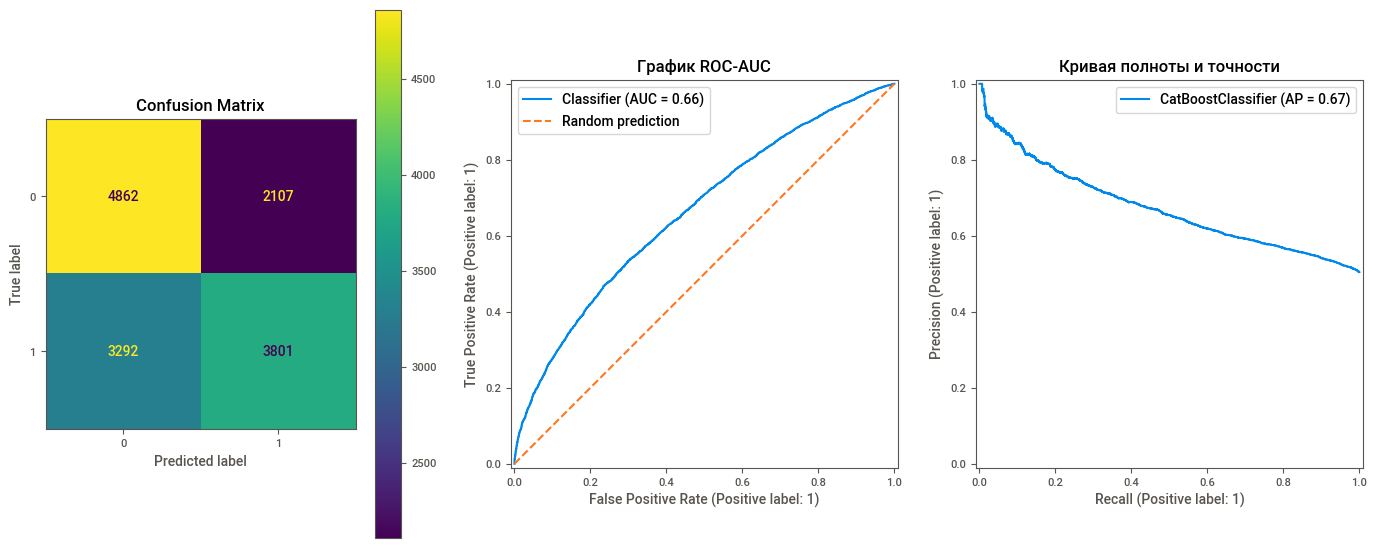

In [72]:
model_score(best_cat, X_test, y_test)

**Промежуточные выводы**
- лучше всего с классификацией справилась модель CatBoost с гиперпараметрами({'depth': 7, 'iterations': 200, 'learning_rate': 0.1}),
- модель не слишком хорошо передсказывает первый класс - вину в ДТП
- основным у нас является предсказание 1 класса - вины водителя в ДПТ - recall - и он составляет около 54%, в то время как невиновность водителя правильно предсказвается в 70% случаев.
- точность модели - 0,62 - есть над чем поработать,
- возможно для дальнейшей работы стоит посмотреть как отразилось бы на модели изменение порога классификации и добавление дополнительных признаков, разработанных на основе имеющихся в БД, но не вошедших в итоговый датафрейм.

## Проведите анализ важности факторов ДТП

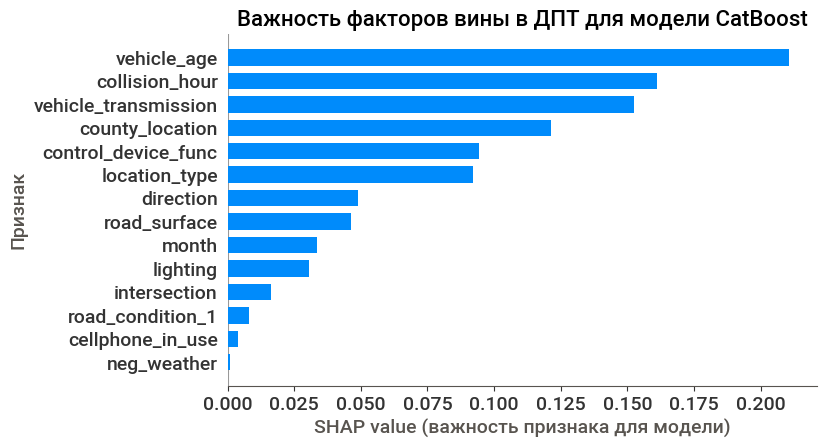

In [73]:
explainer = shap.Explainer(best_cat)
shap_values = explainer.shap_values(X_test)
 
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size= 0.2, show=False, cmap='summer')
fig, ax = plt.gcf(), plt.gca()
# Настройка подписей
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP value (важность признака для модели)", fontsize=14)
ax.set_ylabel("Признак", fontsize=14)
ax.set_title('Важность факторов вины в ДПТ для модели CatBoost', fontsize=16)

plt.show()

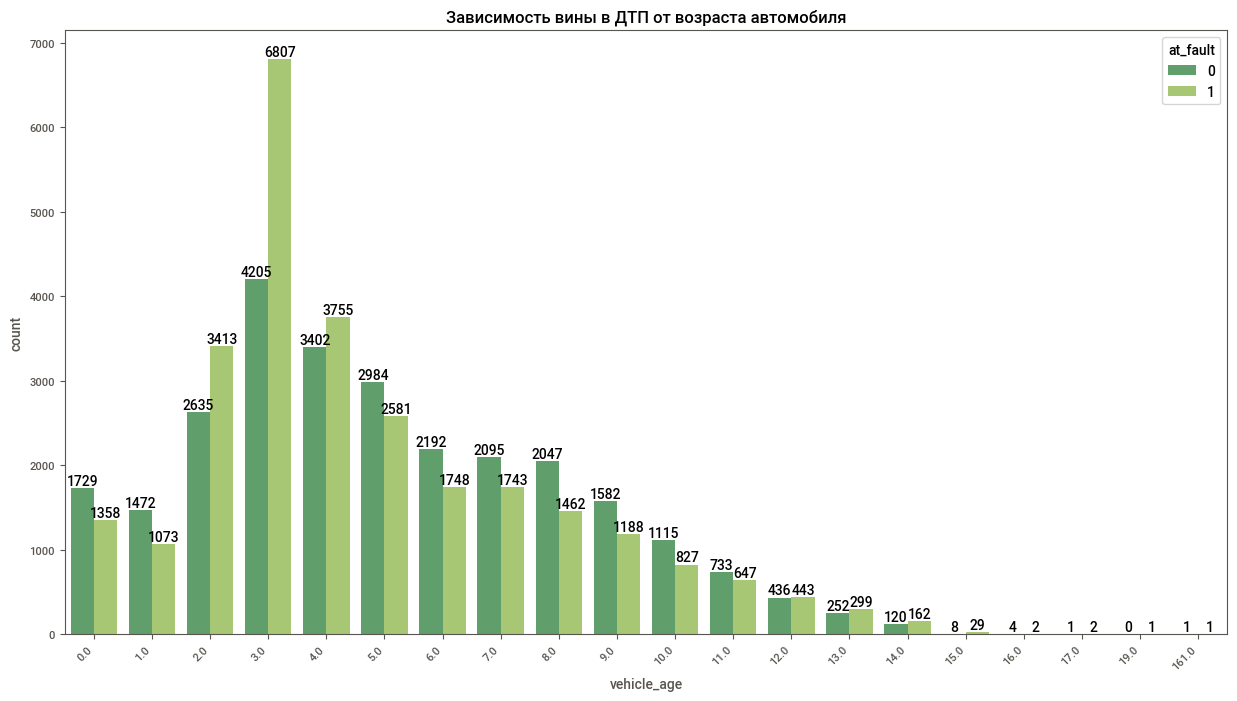

In [74]:
fig, axes = plt.subplots(dpi=100, figsize=(15,8))
axes.set_title('Зависимость вины в ДТП от возраста автомобиля')
ax = sns.countplot(x='vehicle_age', data=df_main, hue='at_fault', ax=axes, palette='summer')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
for i in ax.containers:
    ax.bar_label(i,);

**Выводы по анализу важности признаков :**

- при нашем наборе признаков модель оценивает как самый возраст автомобиля,
- необходимость пересмотреть автопарк,т.к. частота вины водител явозрастает на а/м страрше 12 лет,
- кроме того обратить внимание на закономерность высокого процента вины водителей у а/м 2-4 лет, пик приходится на трехлетние авто, выяснить что за автомобили входят в этоту возрастную группу, провести дополнительное т.о., рассмотреть как связаны основные причины аварий с возрастом а/м.

**Выводы:**
 - в урезанном наборе признаков самым важным становится возраст автомобиля, но предсказания модели далеки от точных, безусловно стоит расширять набор входных признаков.
 
**Рекомендации для дальнейшей работы:**

 Из всего выше написанного можем сделать выводы, что на данный момент найти хорошую модель для прогнозирования ДПТ нам не удалось. Но так как это лишь начало разработки данного проекта, мы видим дальнейшие пути развития:
 - в первую очередь это постараться разработать систему конкретизации маршрута, к которой будет привязана статистика наиболее частых проишествий по данному маршруту(это не просто сводная информаци я привязки количества разных ДПТ к локации, этот вариант был опробован мной, но результатов не принес, поэтому не добавил его в финальнцю версию проекта). Эта система может предупреждать с какими трудностями на данном маршруте может столкнуться водитель, причем стоит ее постоянно актуализировать.
 - ввести дополнительную статистику по типу аварий на участке;
 - в зависимости от маршрута выставлять для водителей предупреждения о местах с фиксированными обьеками, где часто происходят столкновения, перечечениями с велодорожками/масивами, узкими участками с неудобной парковкой. По сути это дублирование дорожных знаков, но предупреждение о дополнительнй аварийности участко может помочь сконцентрировать вннимае водитейлей на проблеме.
 - так же рекомендациями будет являться разработка экспресс теста(оборудование алкозамками автомобилей) и видеофиксации водителя перед началом маршрута для определения степени опьянения,
 - необходимо учитывать профиль самого водителя, что бы понимать его склонность к совершению правонарушений, употрелению алкоголя и прочих факторов. Просто системы определения опьянения явно не достаточно, для точного понимая дальнейшего поведения человека за рулем. Т.е. профиль с ранее совершенными правонарушениями и арендами стоит как-то легально притянуть, но это уже существенное расширение базы данных.
 - так же актуализировать информацию про погодные условия на построенном марштруте и своевременно добавлять их в модель, т.к. от негативных погодных эффектов все-таки зависит частота ДТП.
 - так же стоит протестировать и пообучать модель на других временных промежутках, т.к. рассматривая разбивку ДПТ по месяцем мы видели, что 2012год отличается от общей динамики.

## Выводы

 - подключились к БД, проверили таблицы, провели первичный осмотр;
 - провели статистический анализ факторов ДТП;
 - собрали итоговый набор данных и отобрали необходимые для моделирования;
 - проведен анализ данных при помощи библиотеки sweetvis:
    - явные дубликаты не обнаружены;
    - заполнены пропуски, убраны неявные дубликаты, часть признаков переведа в булевые значения;
    - мультиколлинеарность не обнаружена среди признаков;
    
 - построены 3 модели - LogisticRegression, RandomForest, CatBoostClassifier - подобраны гиперпараметры методом GridSeach;
 - расширено пространство признаков опробована модели CatBoost;
 - лучшей моделью выбрана CaTBoost c гиперпараметрами ({'depth': 7, 'iterations': 200, 'learning_rate': 0.1})б
 - основными признаками оказывающими влияние на предсказание модели признаны - состояние водителя,  дополнительный участник правонарушения и категория правонарушения;
 - даны рекомендации для дальнейшего развития предсказательной модели и улучшения сервиса.